In [54]:
import ssl
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

set_config(transform_output = "pandas")

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv('https://raw.githubusercontent.com/ElieLECAS/ML_avance/fil_rouge/activite_finale/data/census_us.csv')
df.drop(['fnlwgt'], axis=1, inplace=True)
display(df.head(5))

age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private       11th  Married-civ-spouse  Handlers-cleaners   
4   37           Private    Masters  Married-civ-spouse    Exec-managerial   

    relationship   race     sex  capital_gain  capital_loss  hours_per_week  \
0  Not-in-family  White    Male        2174.0           0.0            40.0   
1        Husband  White    Male           0.0           0.0            13.0   
2  Not-in-family  White    Male           0.0           0.0            40.0   
3        Husband  Black    Male           0.0           0.0            40.0   
4           Wife  White  Female           0.0           0.0            40.0   

  income  
0  <=50K  
1  <=50K  
2  <=50K  
3  <=50K  
4  <=50K

['<=50K' '>50K']


In [55]:
print(f'nb dupe {df.loc[df.duplicated()].shape[0]}')
df = df.drop_duplicates(ignore_index=True)
df.describe()

nb dupe 6340


age  capital_gain  capital_loss  hours_per_week
count  37492.000000  37492.000000  37492.000000    37492.000000
mean      39.644618   1257.112931    102.925024       40.702550
std       13.878898   7993.566016    434.941795       13.013938
min       17.000000      0.000000      0.000000        1.000000
25%       29.000000      0.000000      0.000000       38.000000
50%       38.000000      0.000000      0.000000       40.000000
75%       49.000000      0.000000      0.000000       45.000000
max       90.000000  99999.000000   4356.000000       99.000000

# Analyse
[SweetViz](https://github.com/fbdesignpro/sweetviz)

## tout le jeu de données

                                             |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



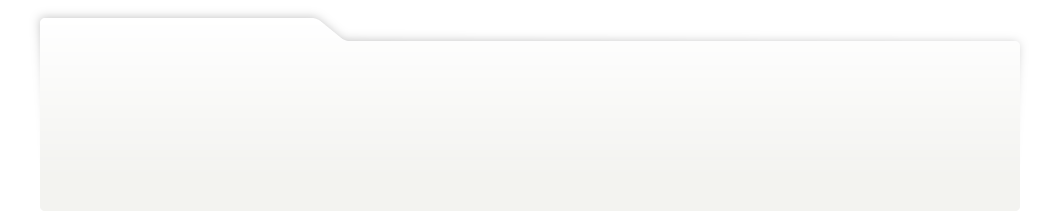
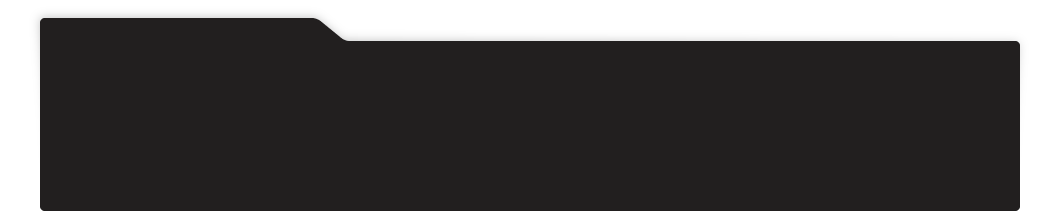
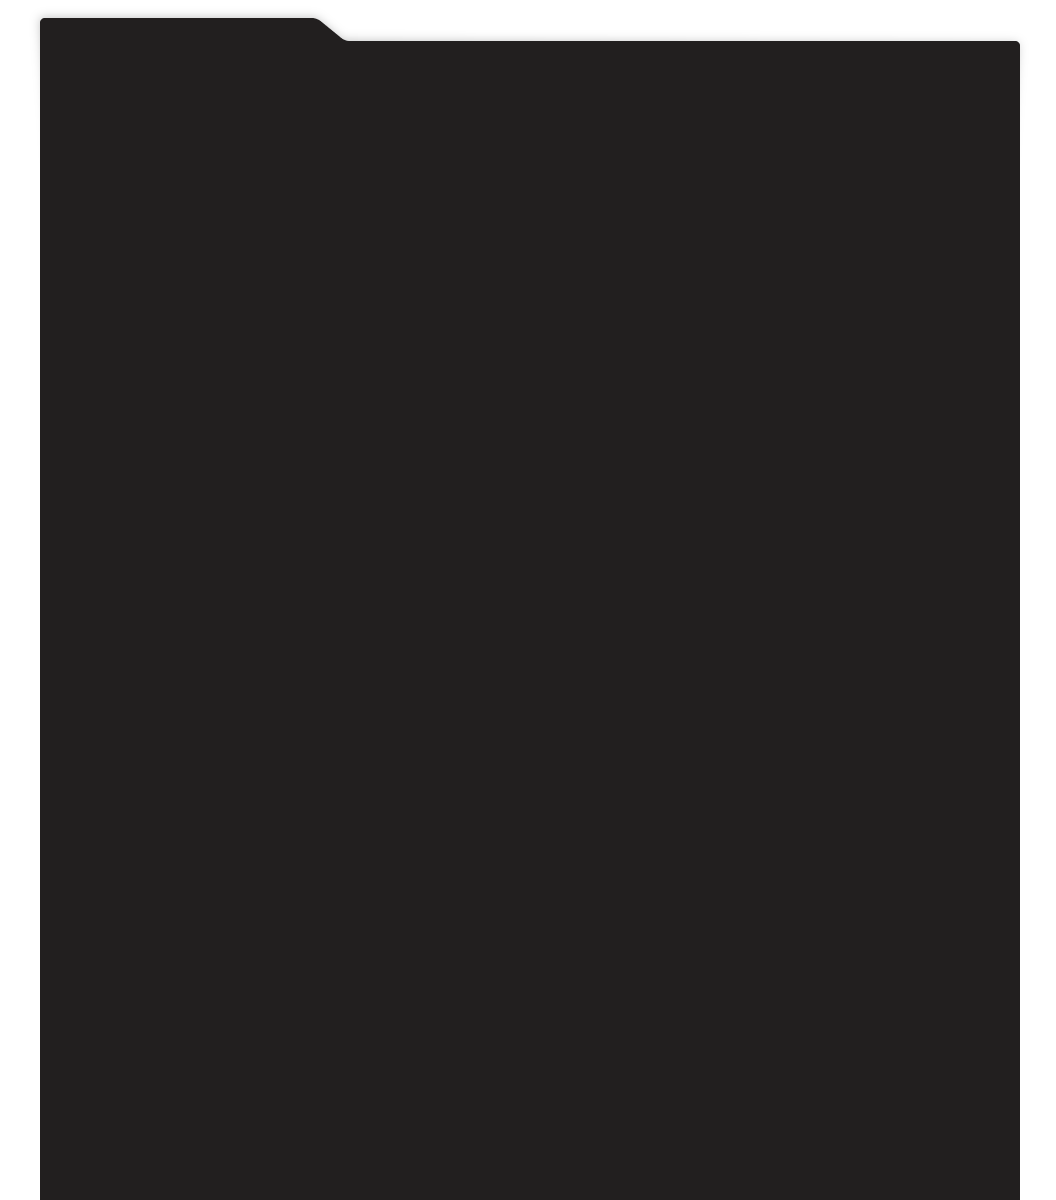
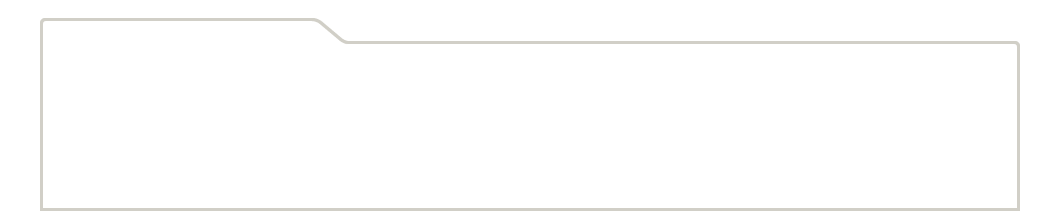
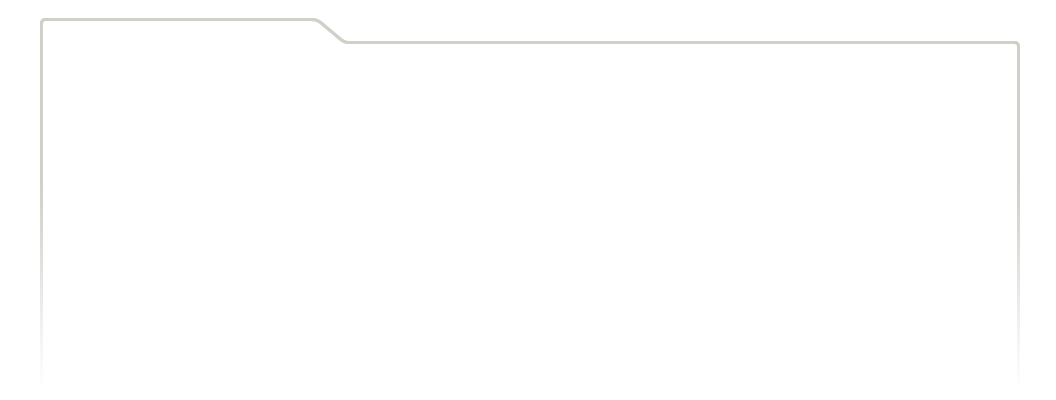
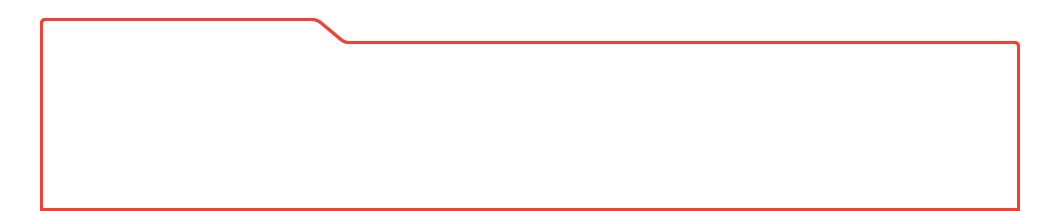
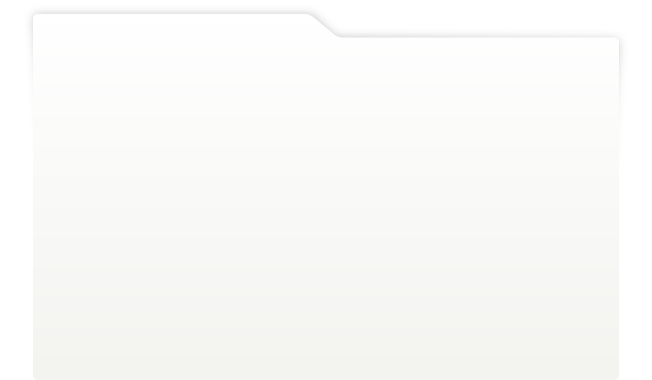
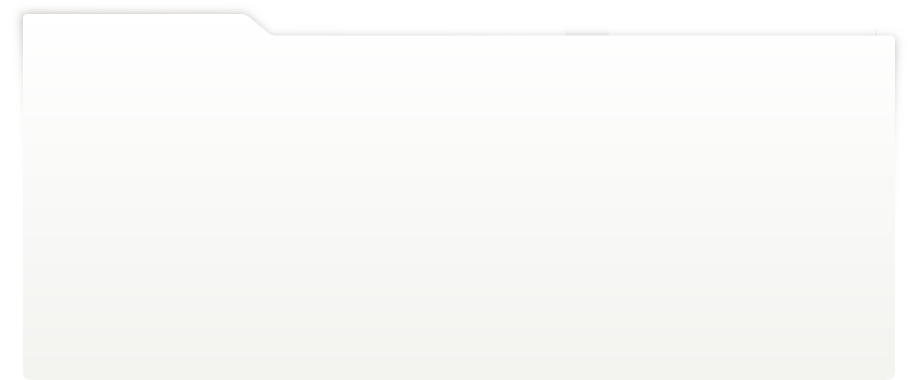
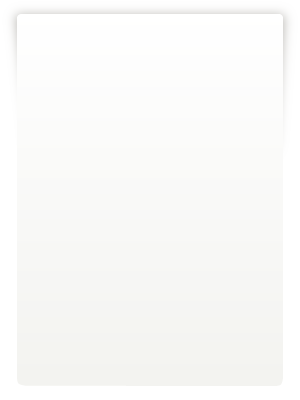
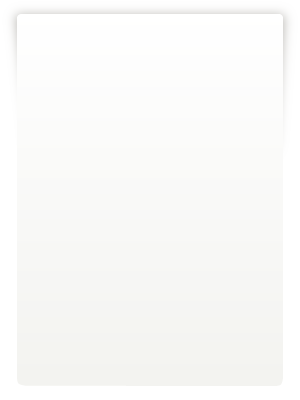
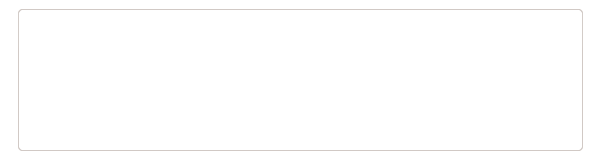
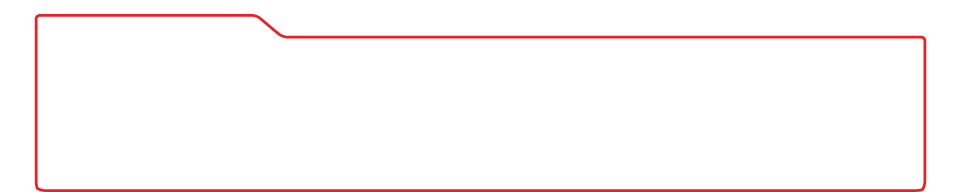
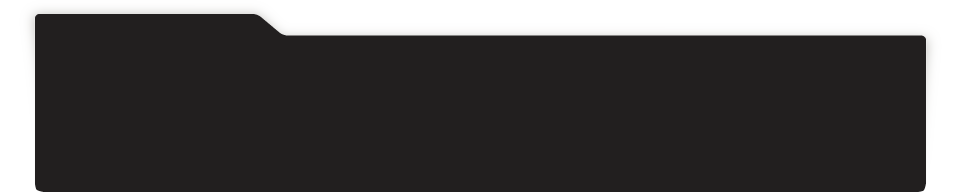
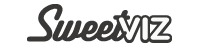
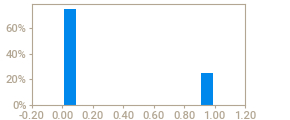
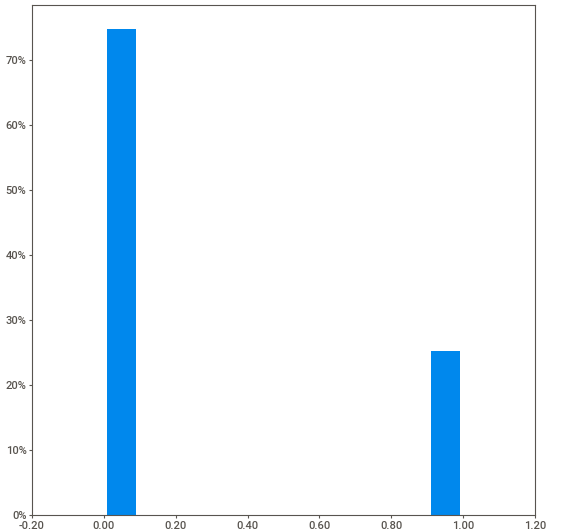
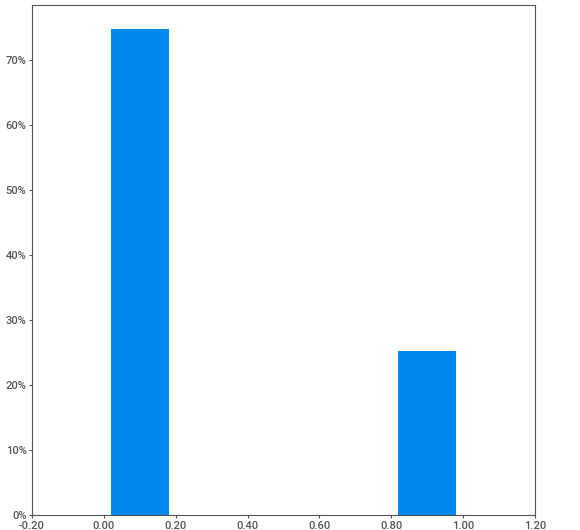
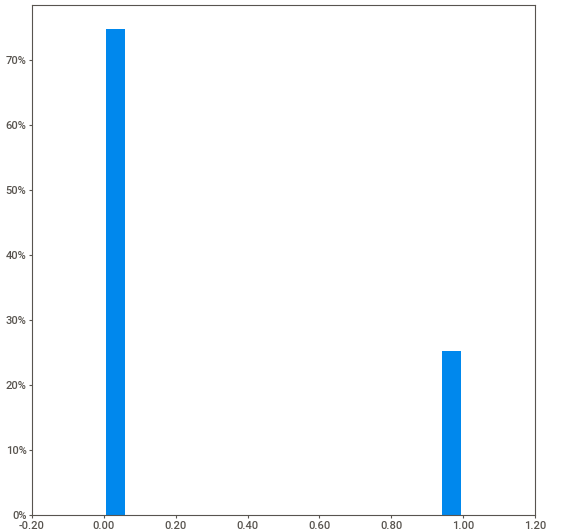
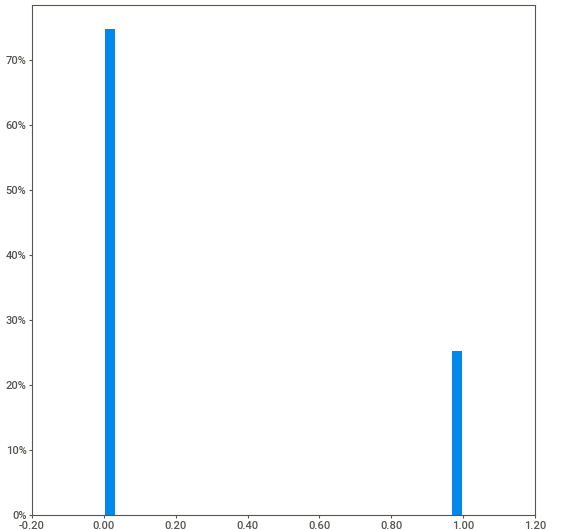
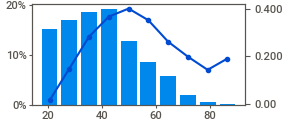
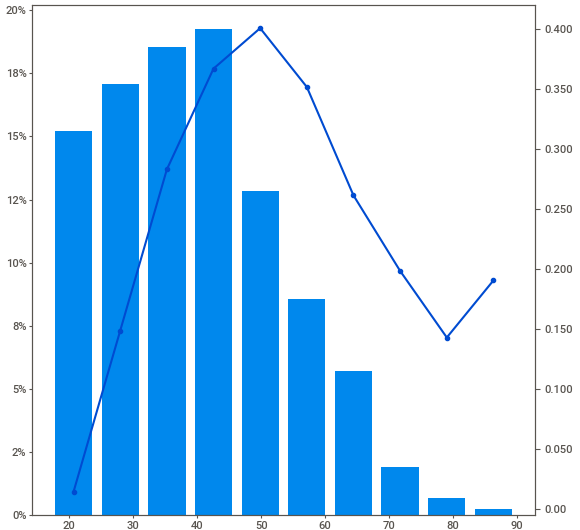
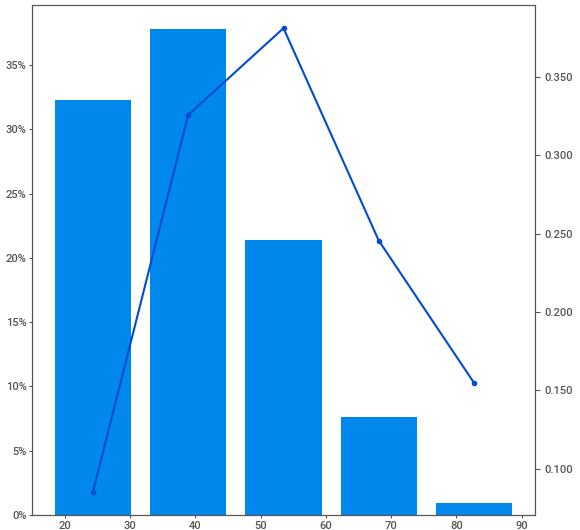
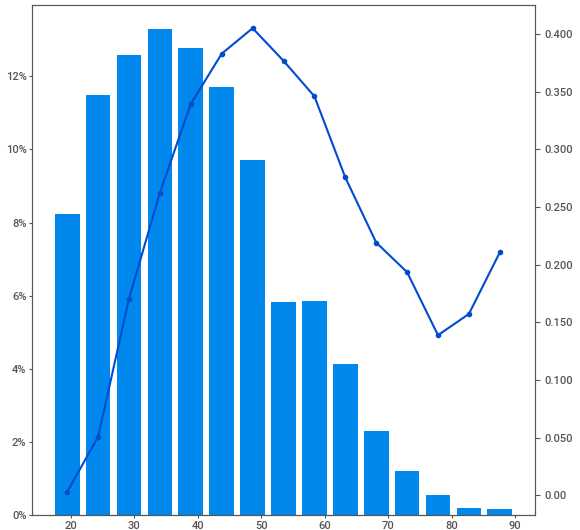
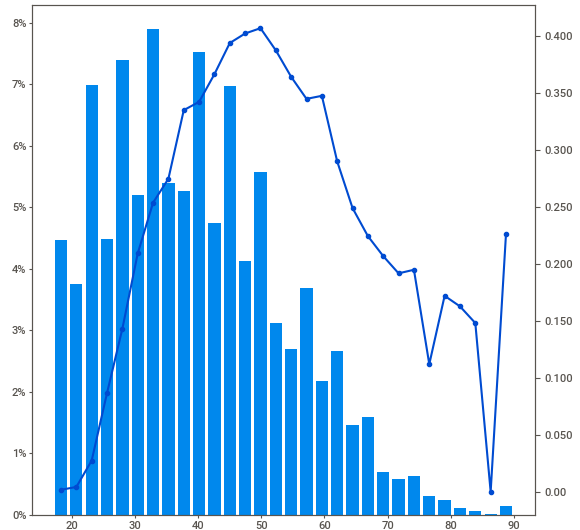
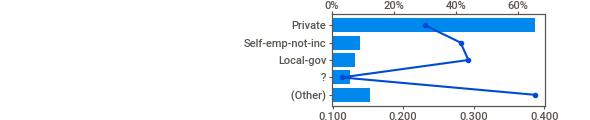
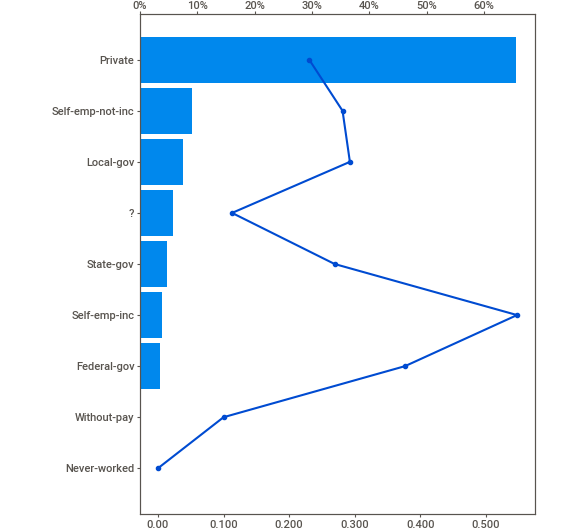
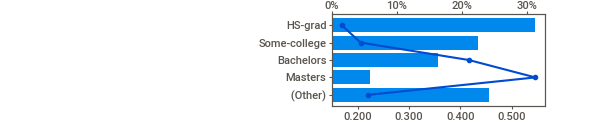
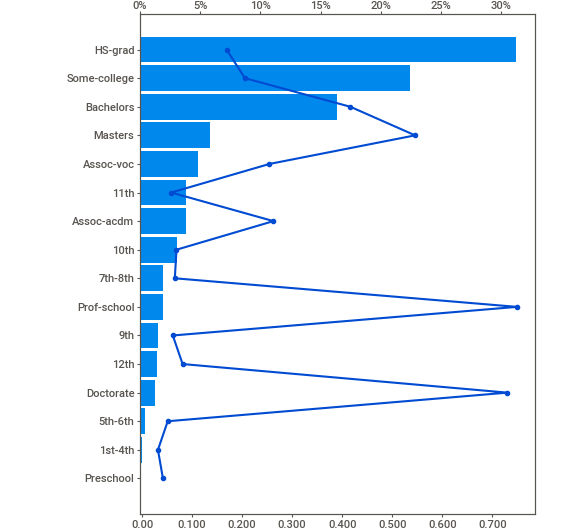
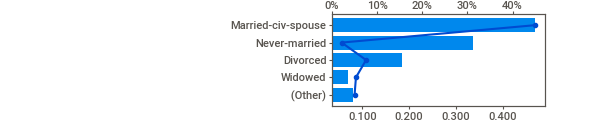
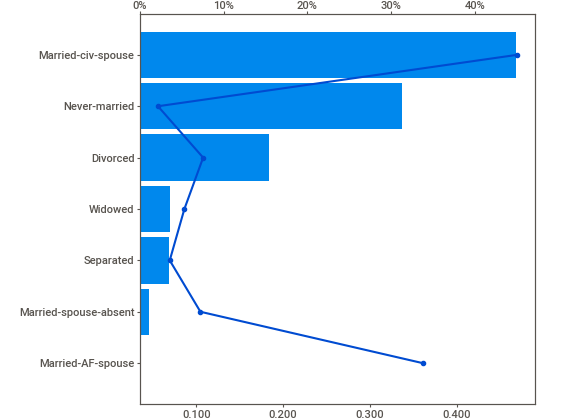
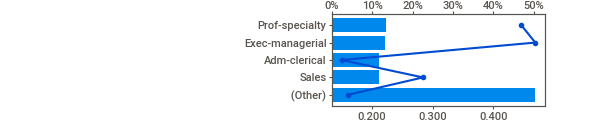
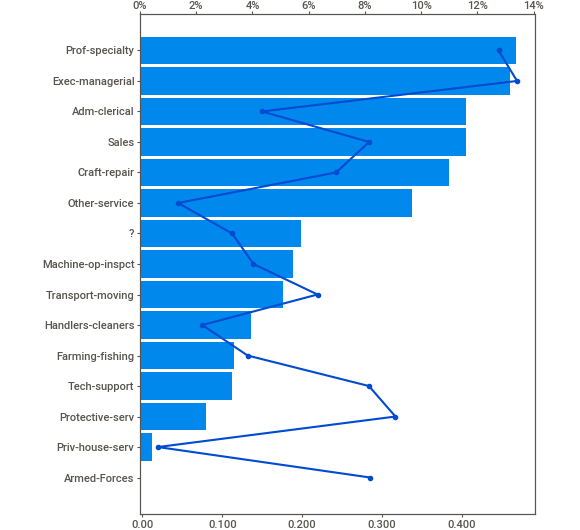
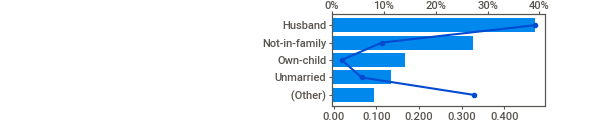
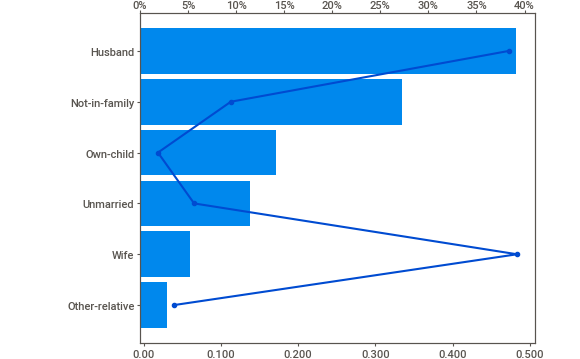
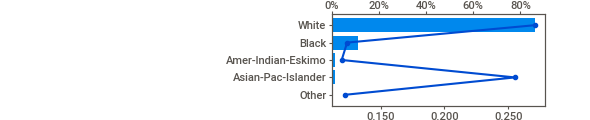
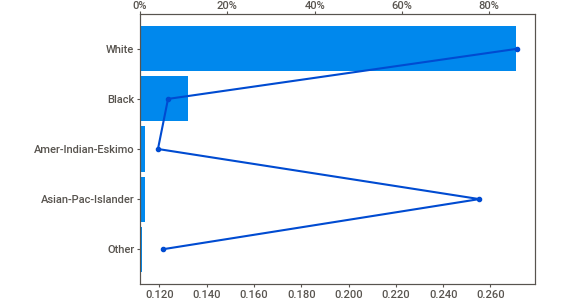
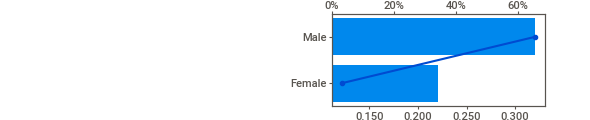
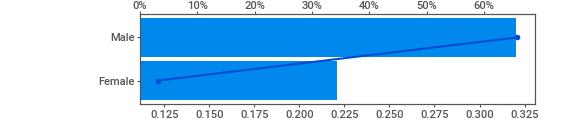
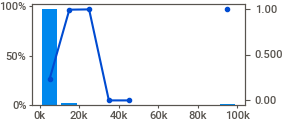
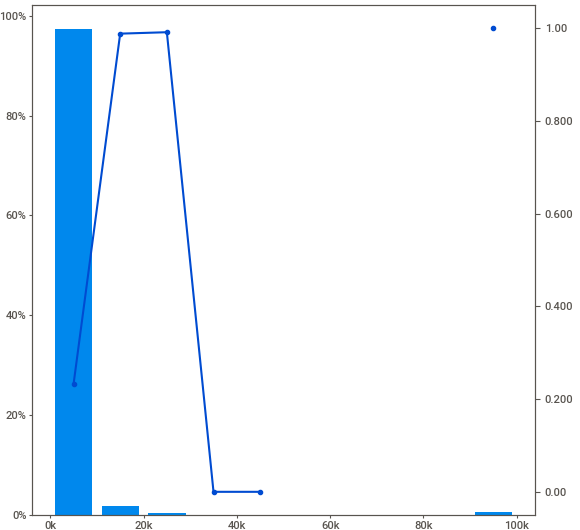
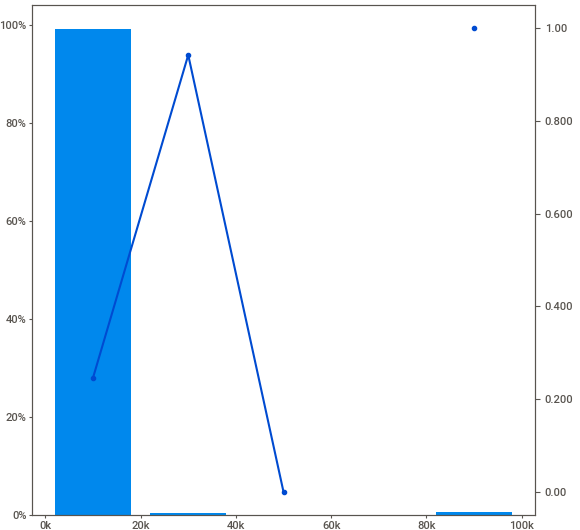
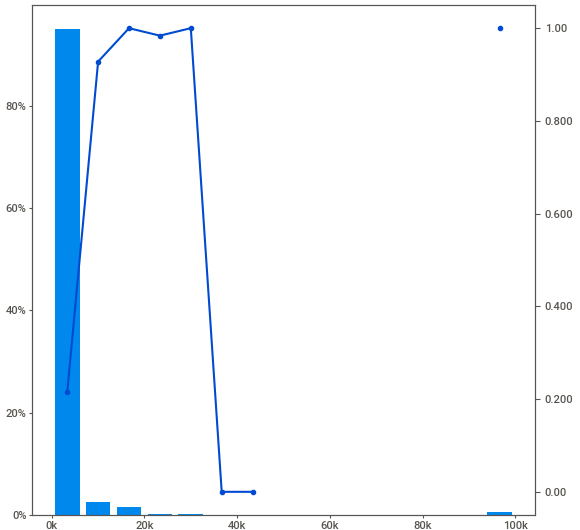
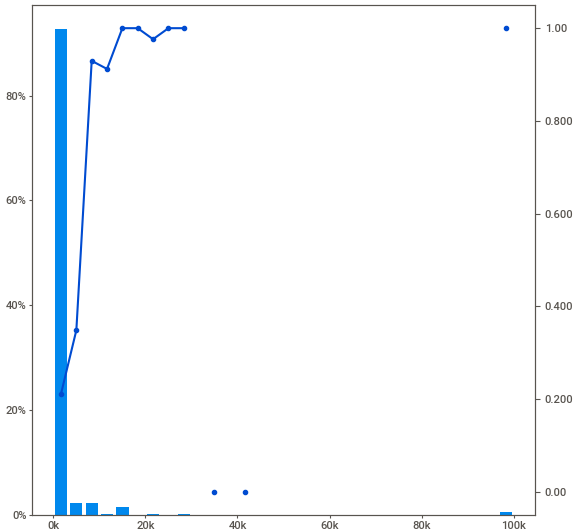
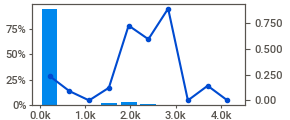
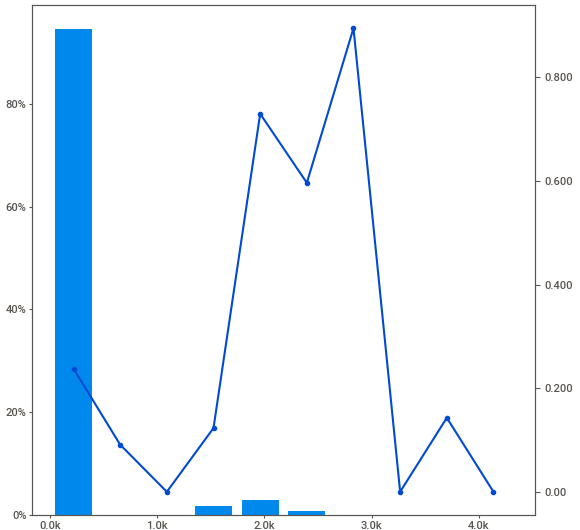
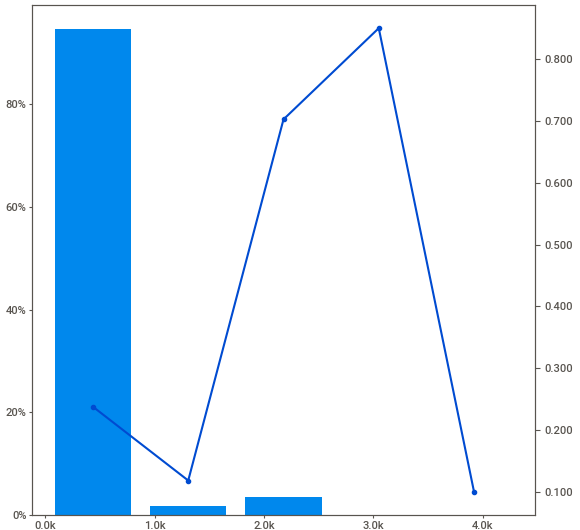
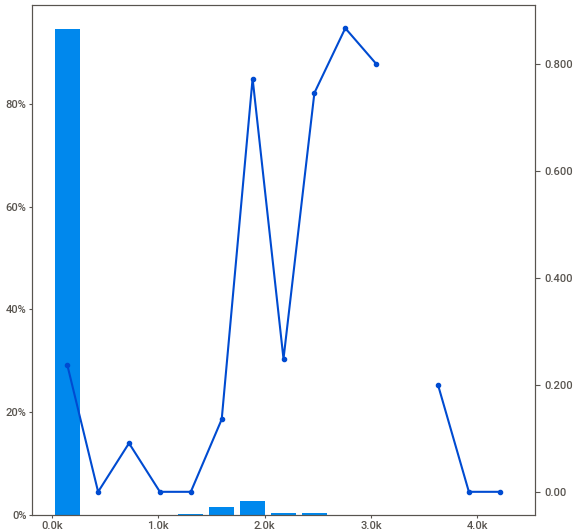
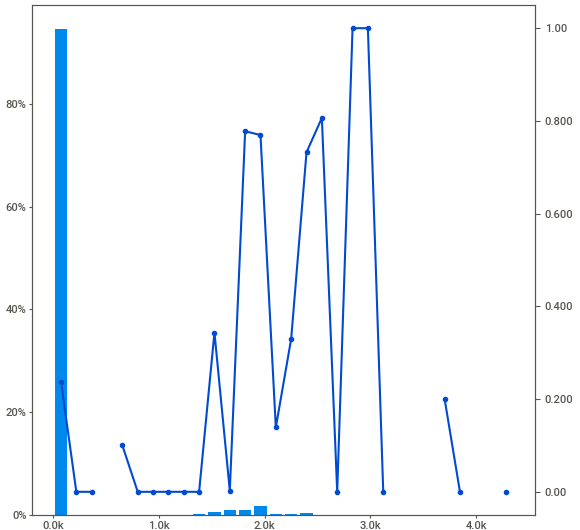
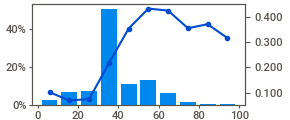
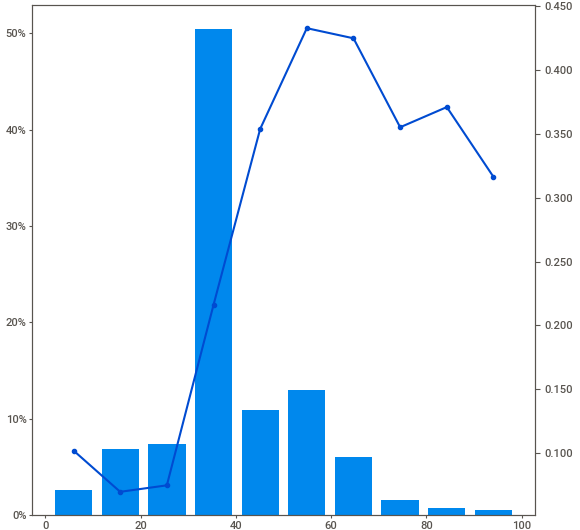
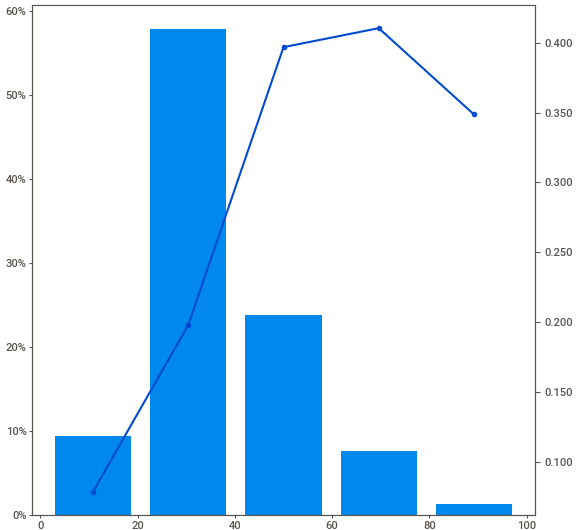
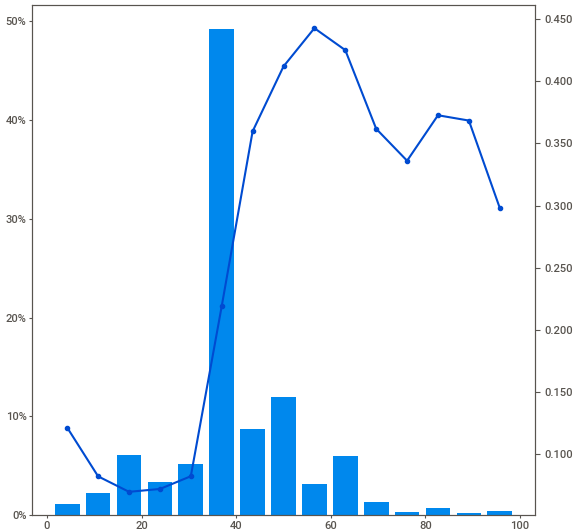
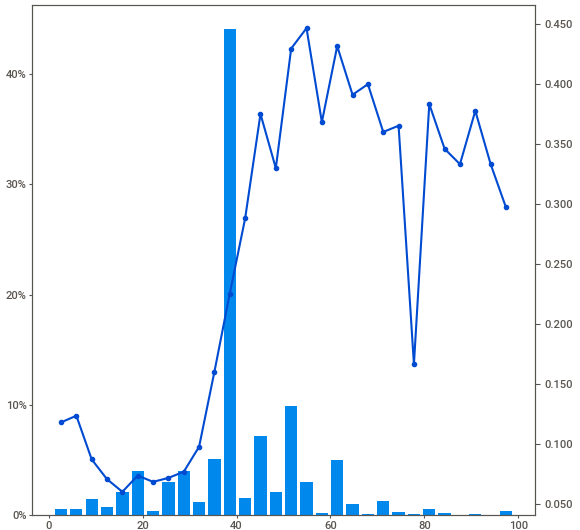
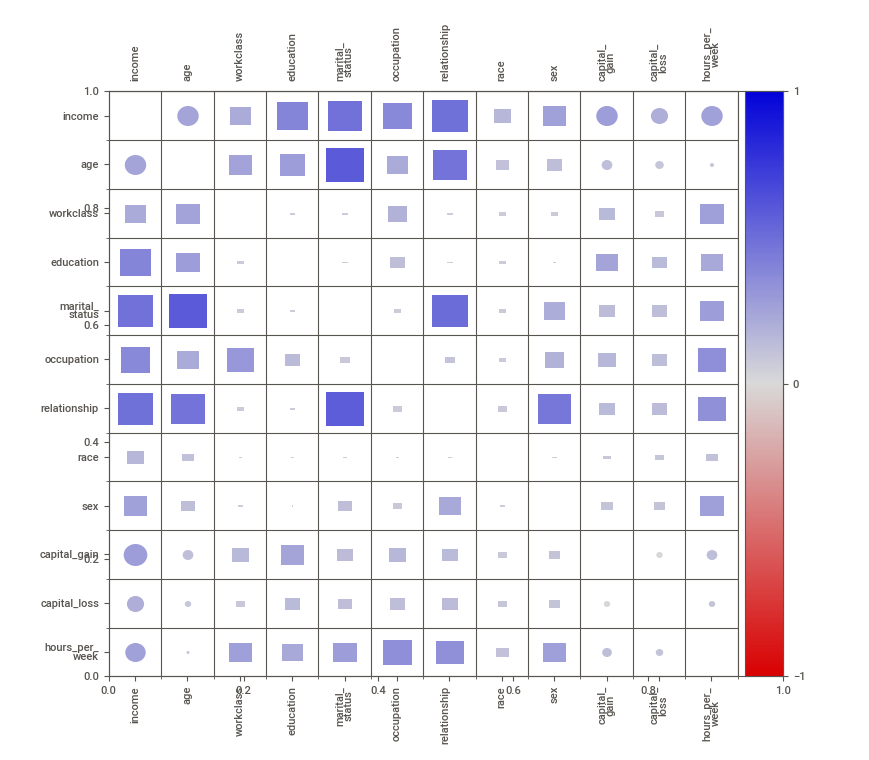
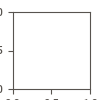

In [56]:
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
feature_config = sv.FeatureConfig(force_num=["income"])

df_viz = df.copy()
le = LabelEncoder()
df_viz['income'] = le.fit_transform(df_viz['income'])
df_viz['age'] = pd.to_numeric(df_viz['age'], errors='coerce')
df_viz['capital_gain'] = pd.to_numeric(df_viz['capital_gain'], errors='coerce')
df_viz['capital_loss'] = pd.to_numeric(df_viz['capital_loss'], errors='coerce')
df_viz['hours_per_week'] = pd.to_numeric(df_viz['hours_per_week'], errors='coerce')

sweet_report = sv.analyze(df_viz, 'income', feat_cfg=feature_config)
sweet_report.show_notebook()

## Comparaison

                                             |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



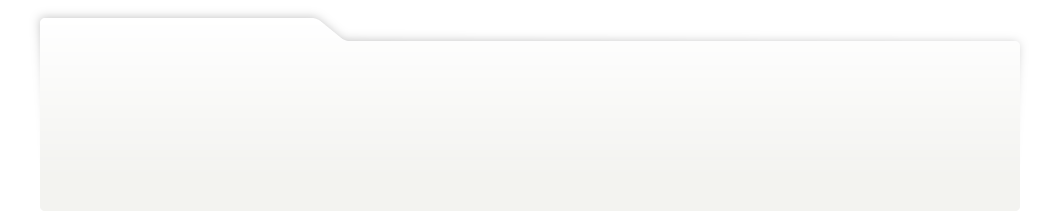
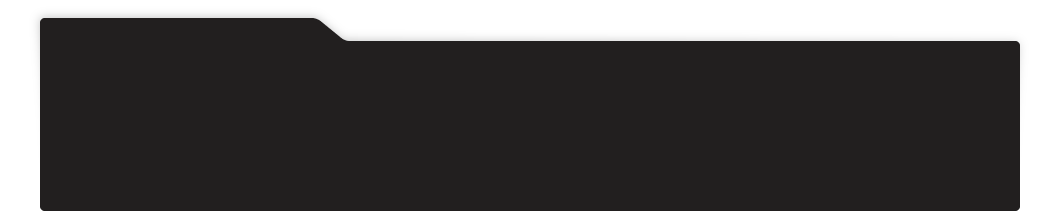
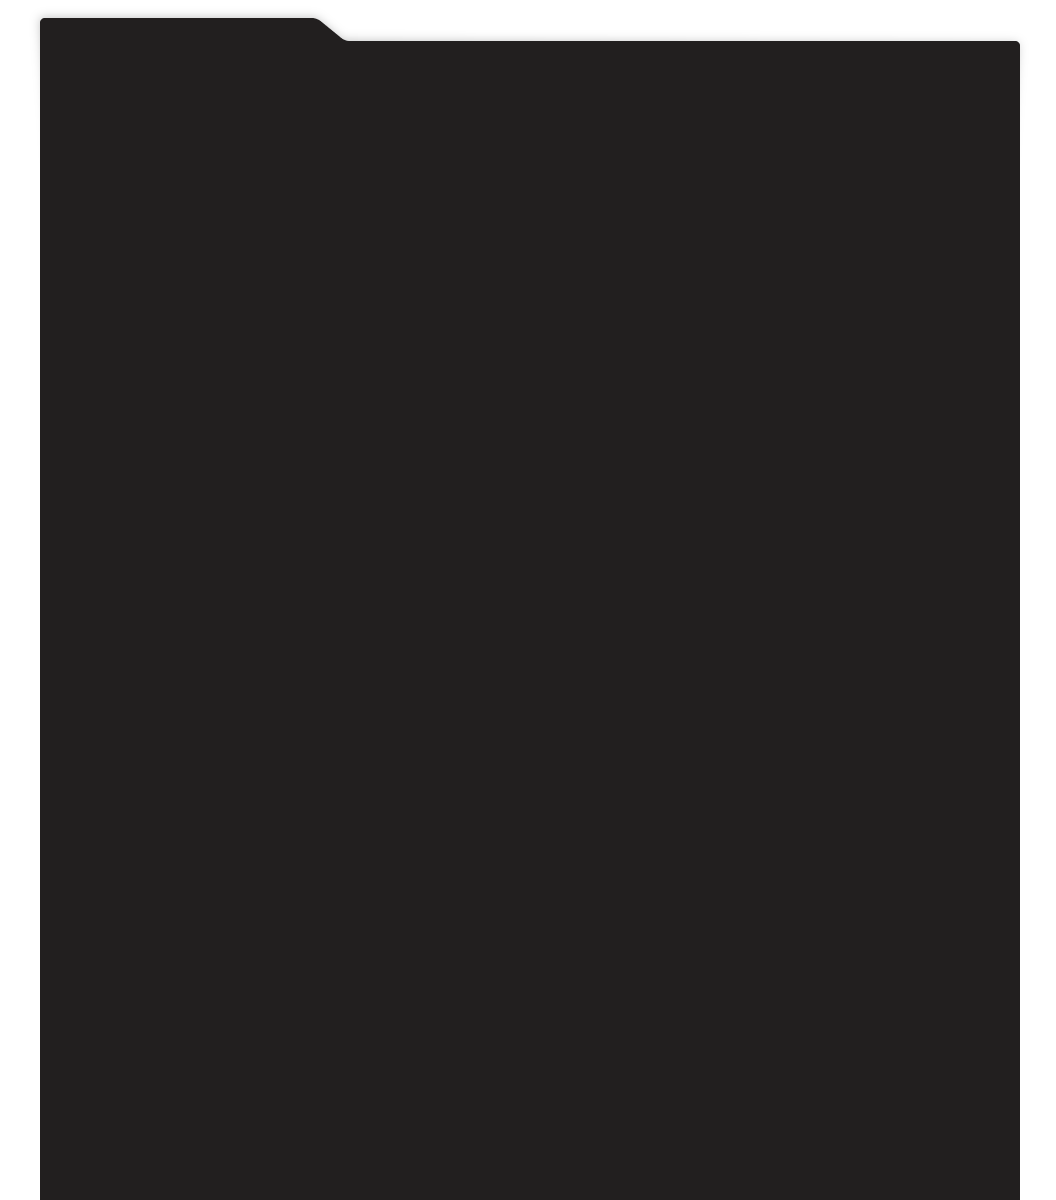
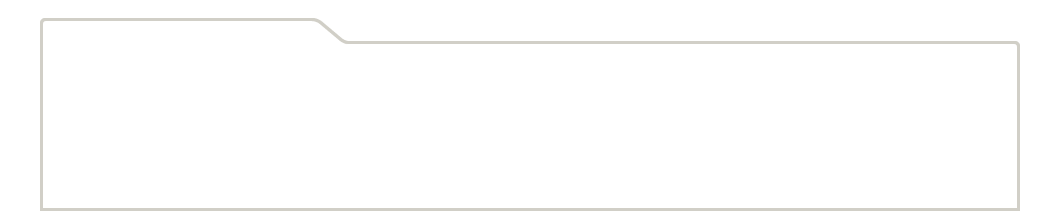
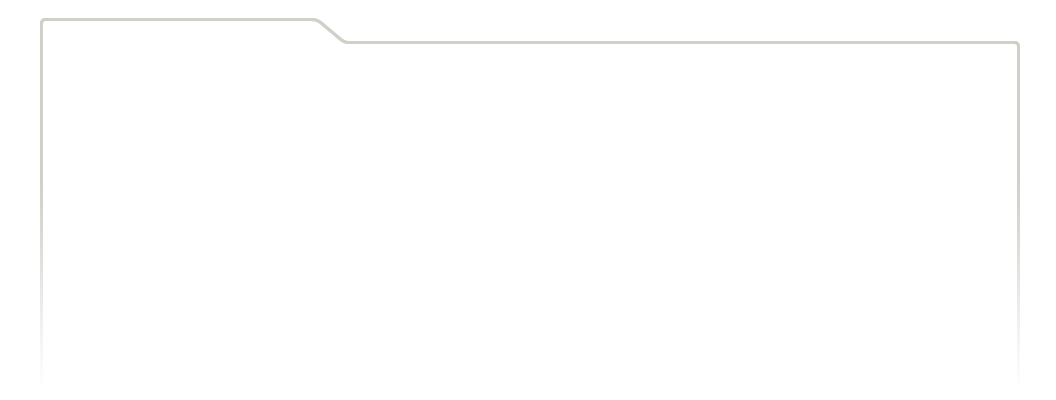
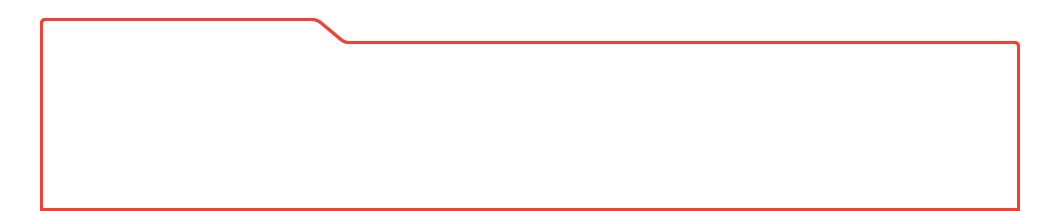
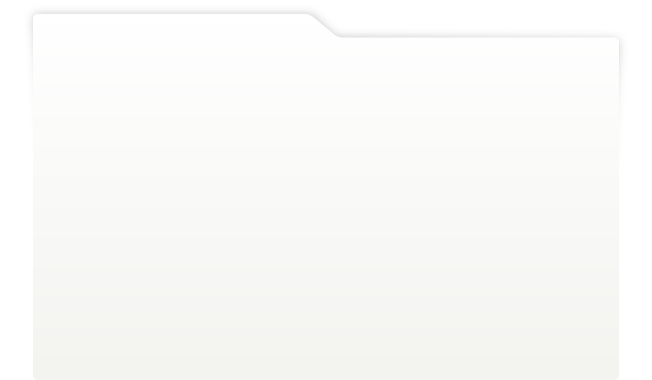
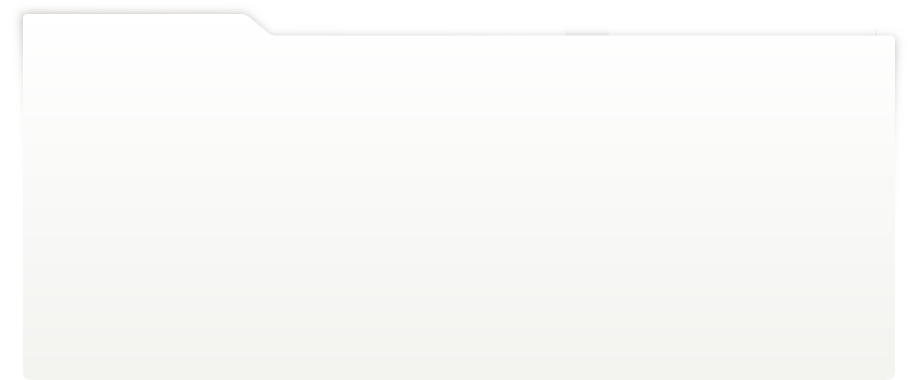
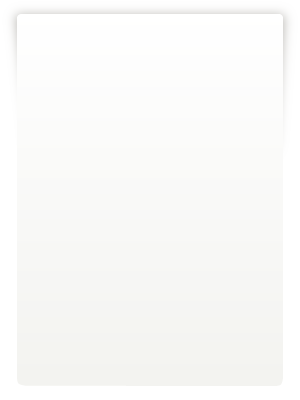
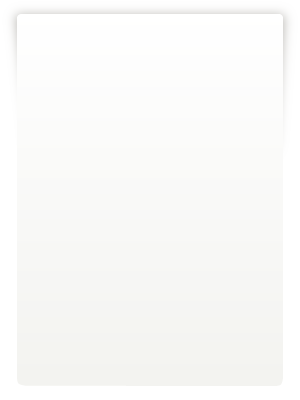
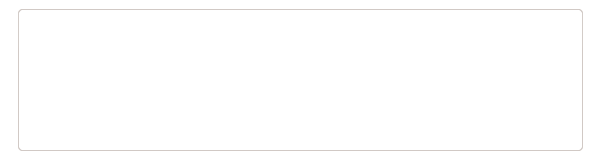
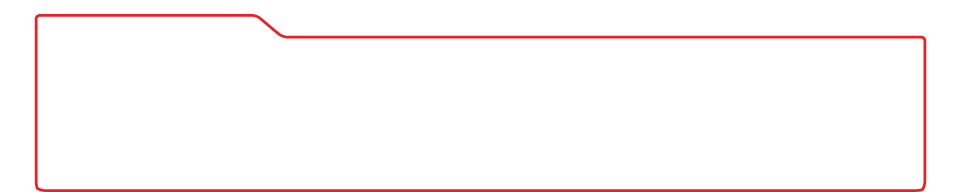
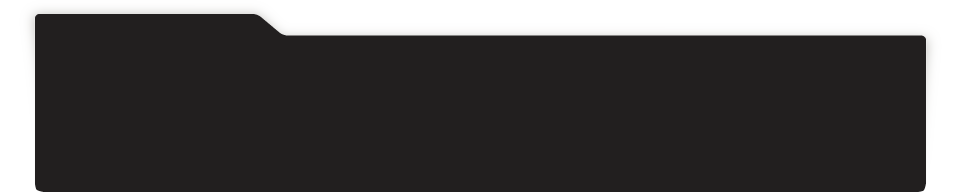
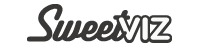
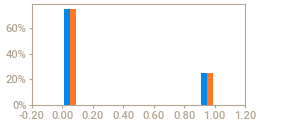
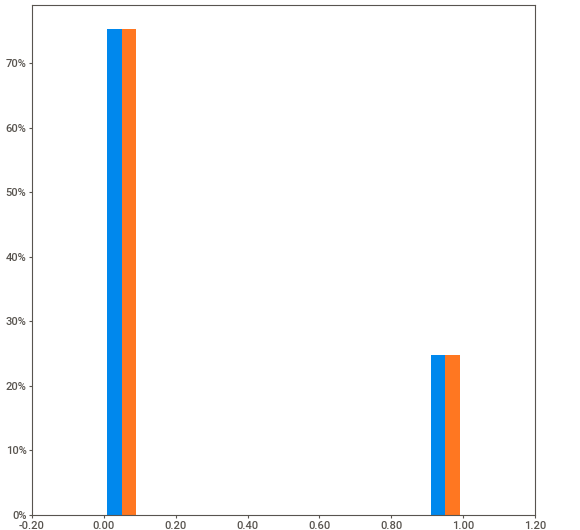
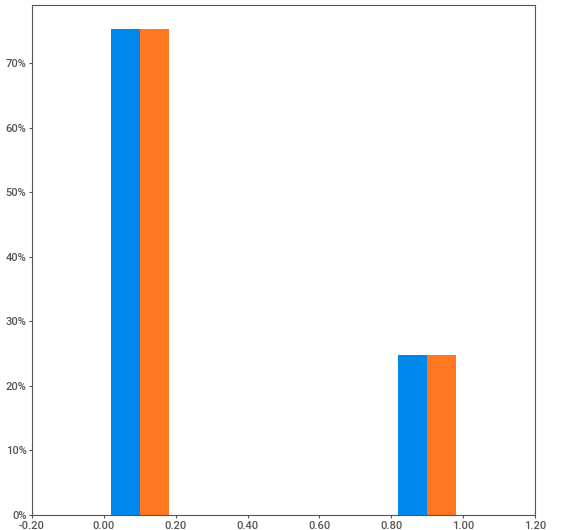
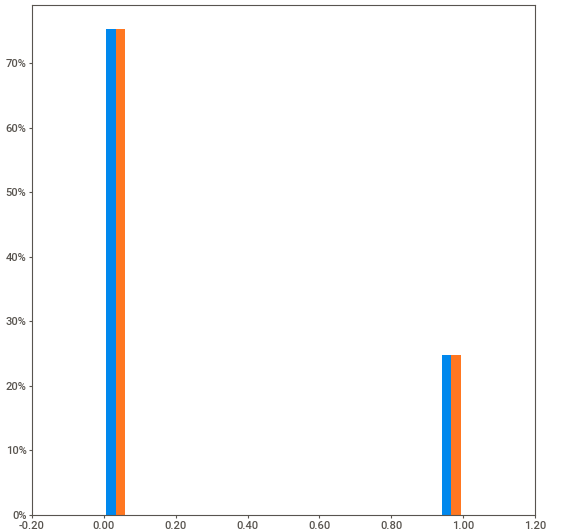
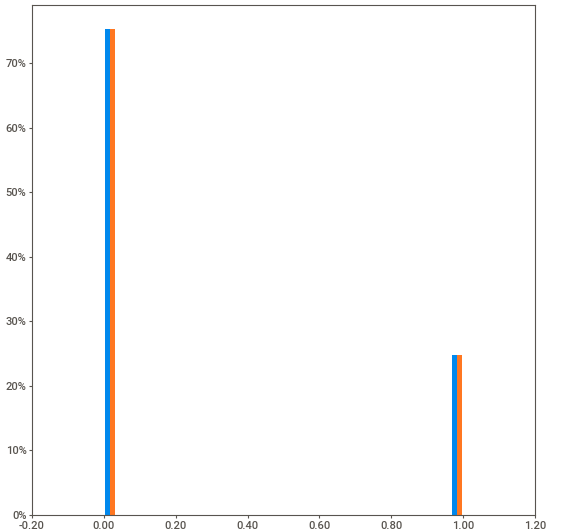
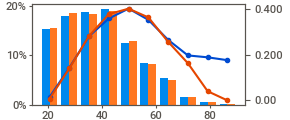
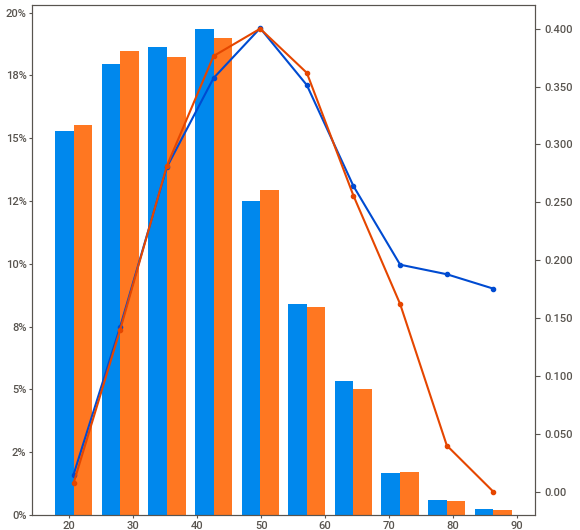
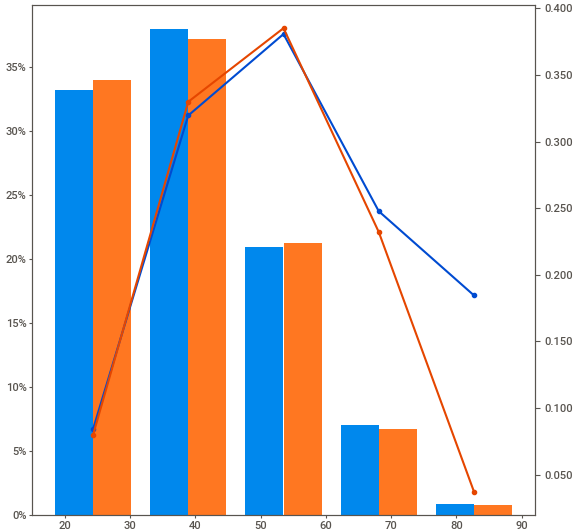
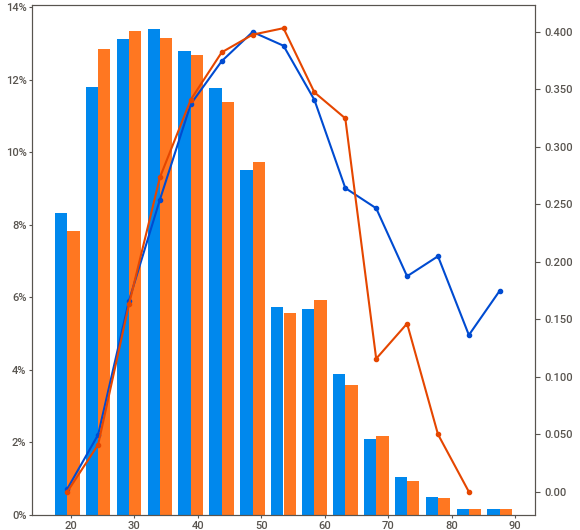
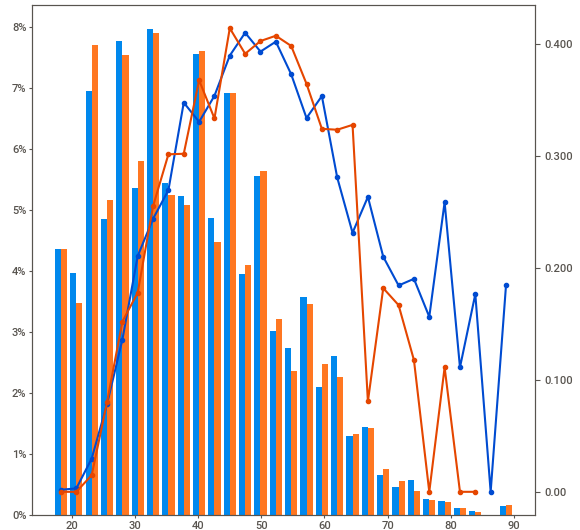
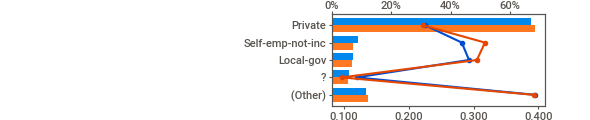
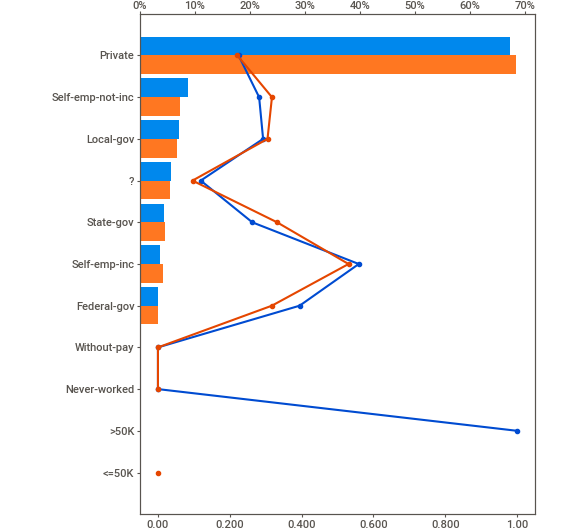
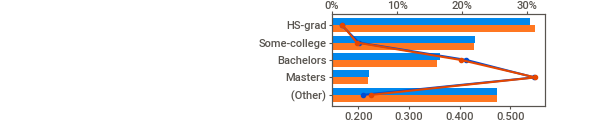
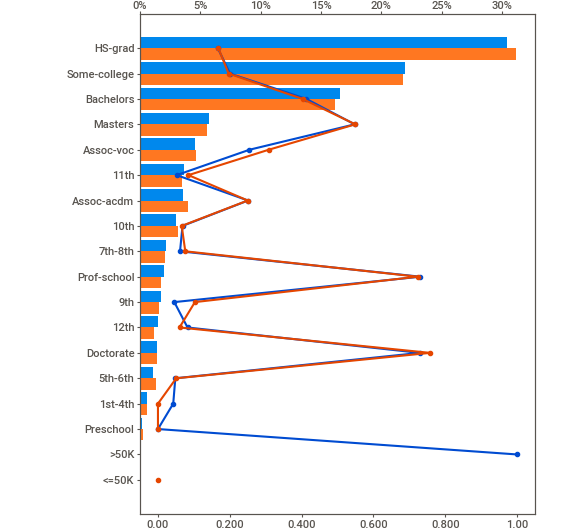
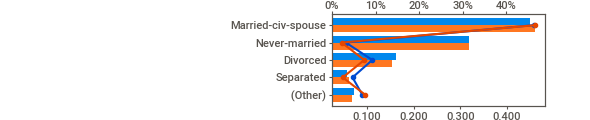
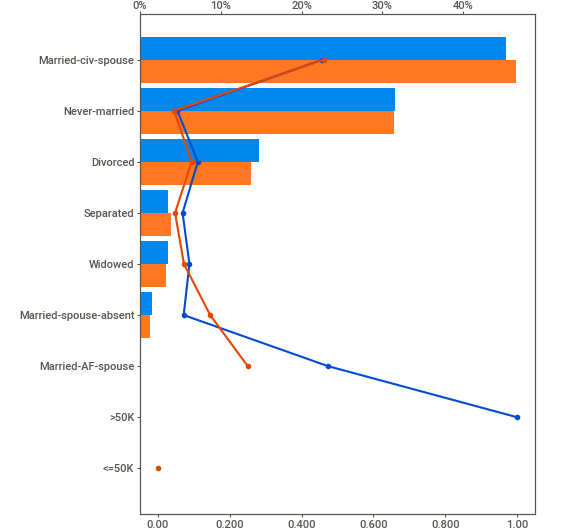
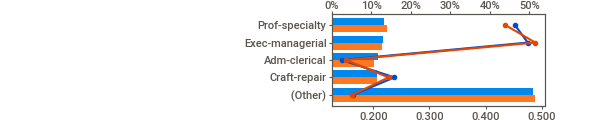
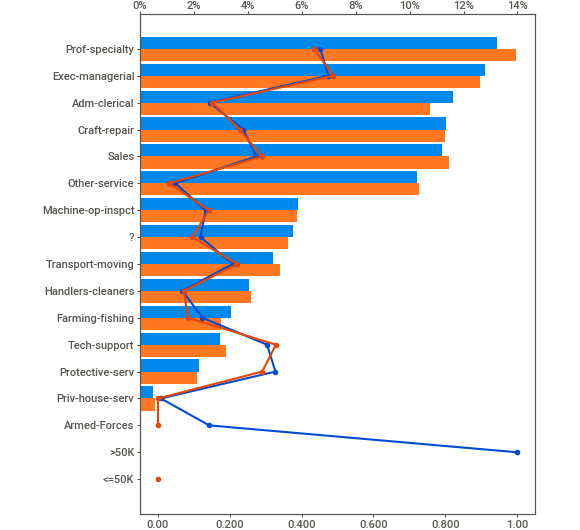
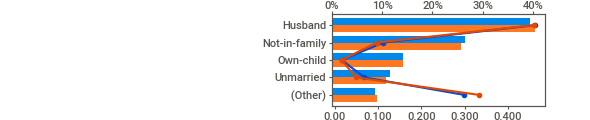
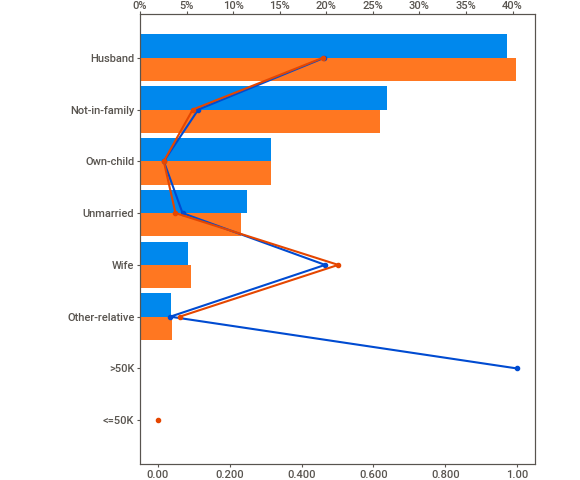
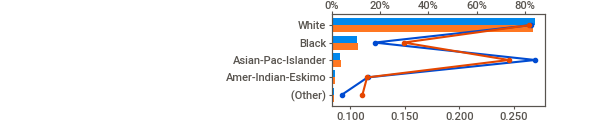
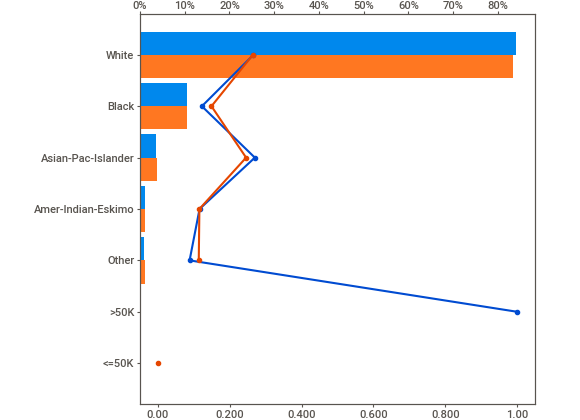
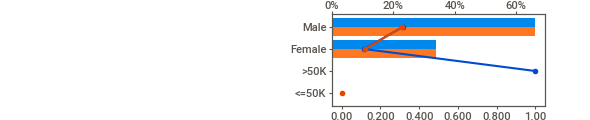
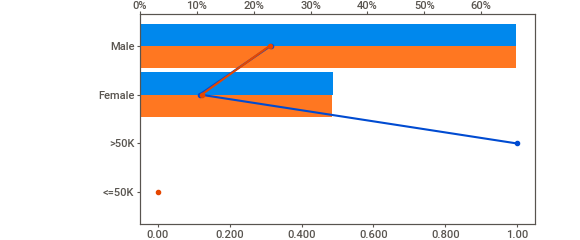
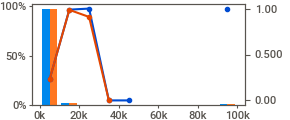
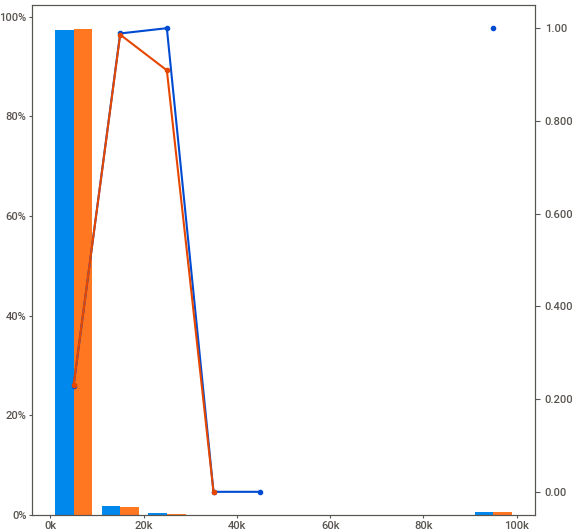
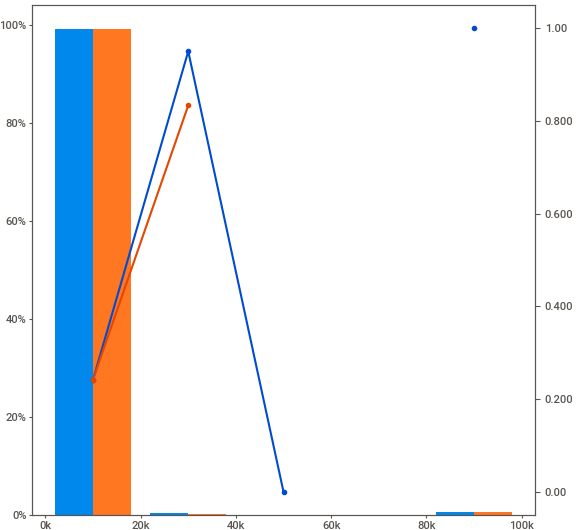
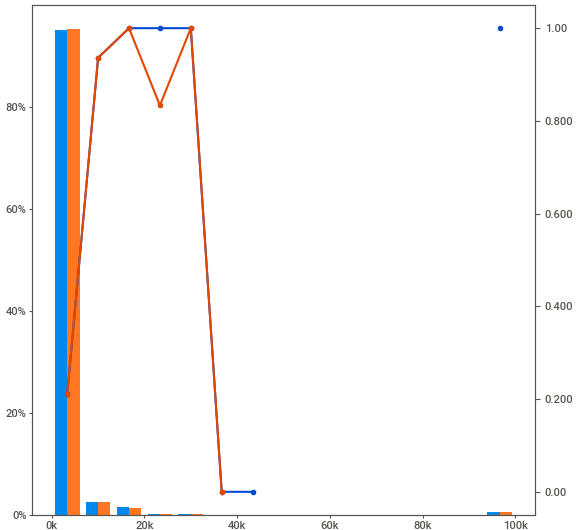
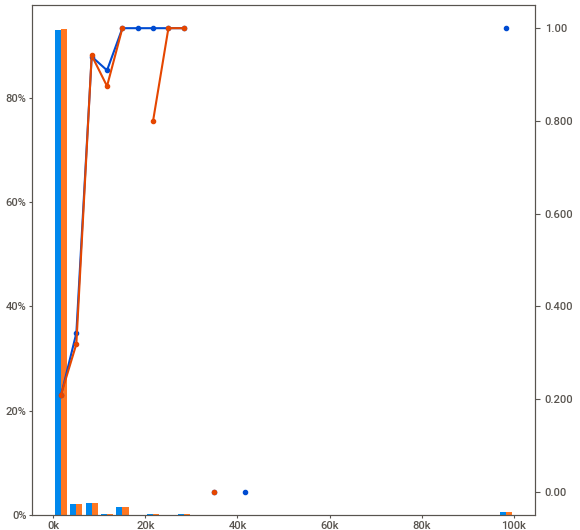
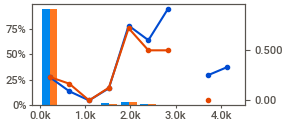
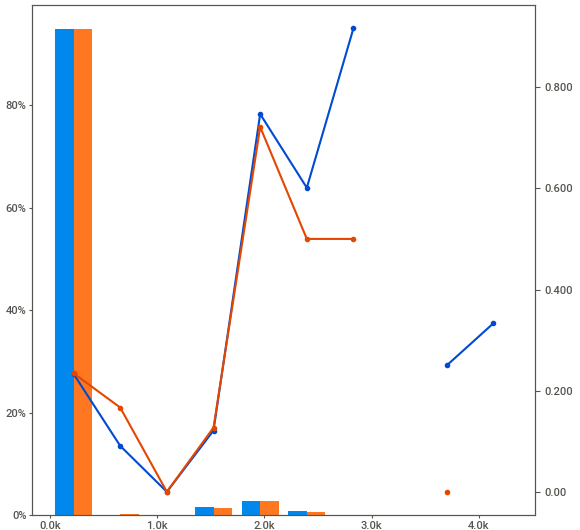
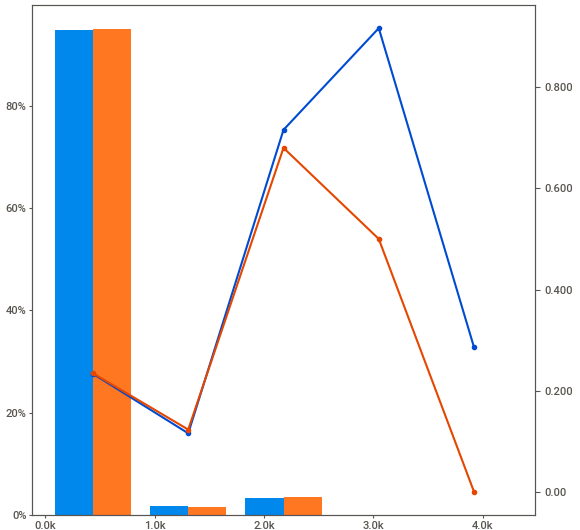
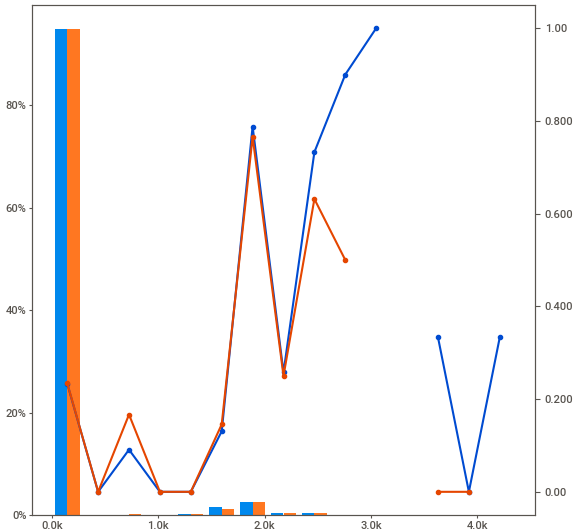
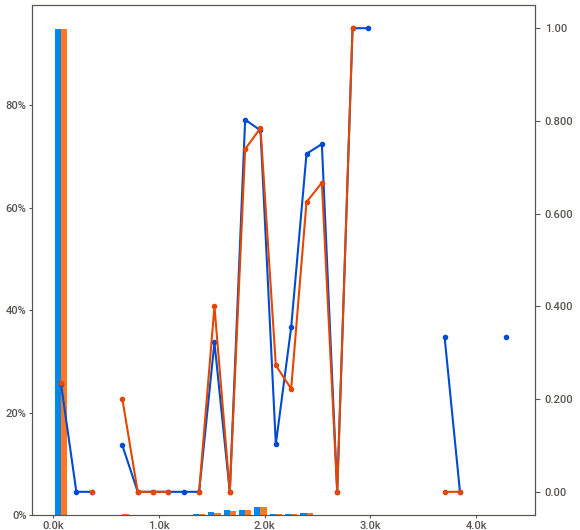
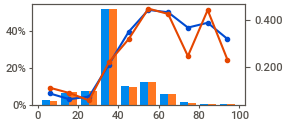
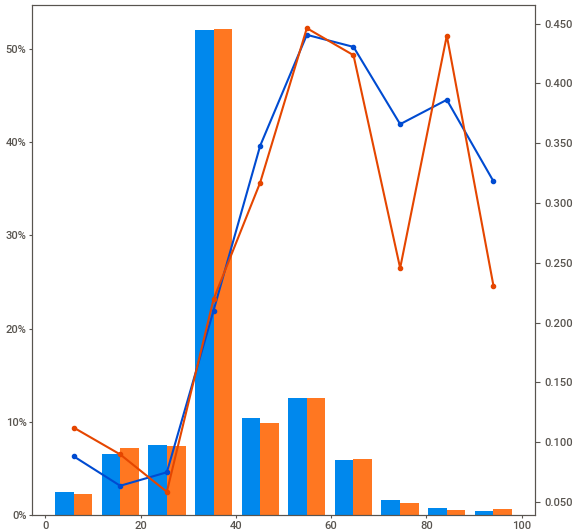
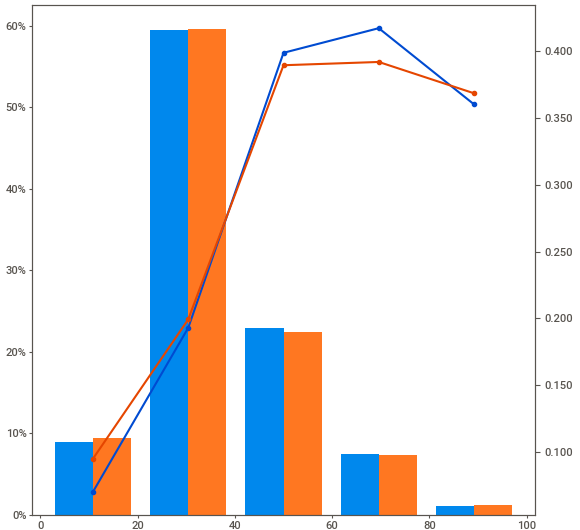
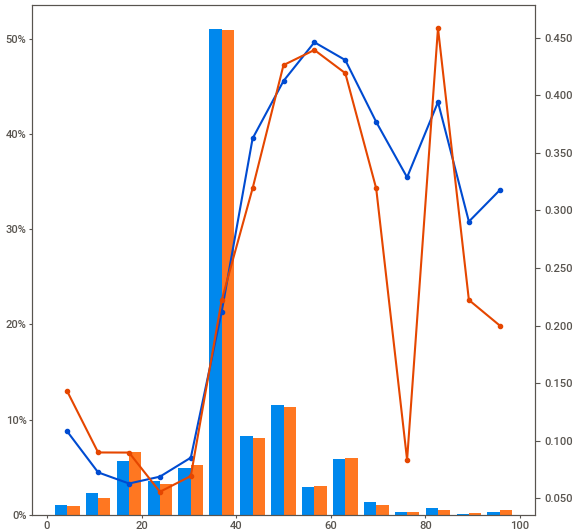
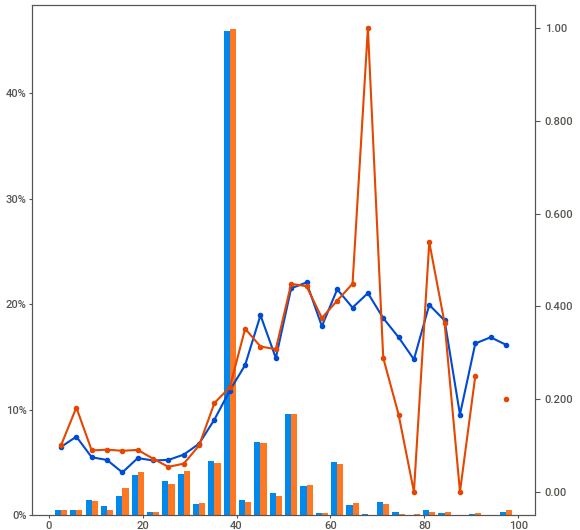
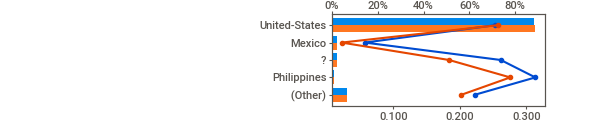
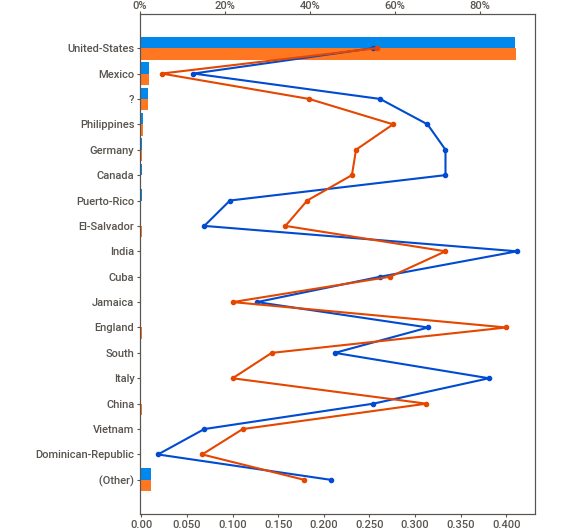
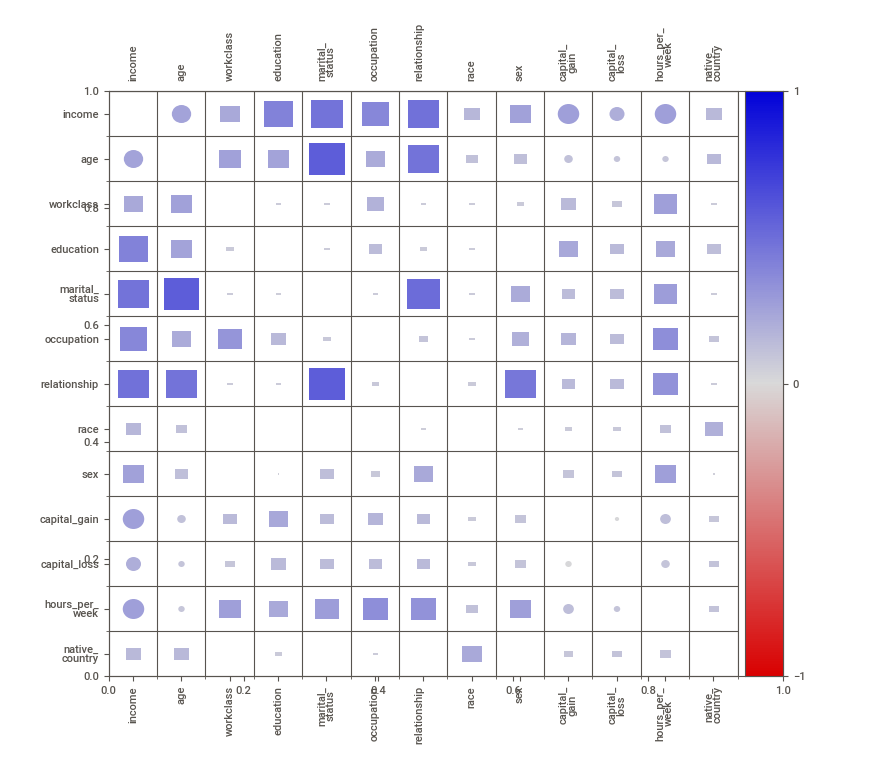
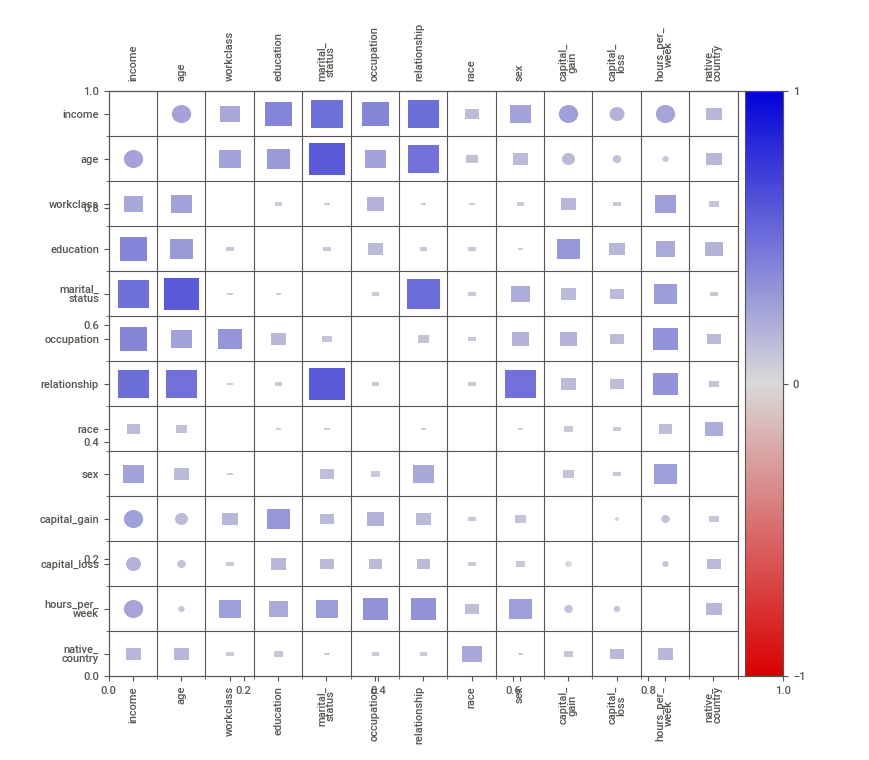

In [38]:
X_train, X_test = train_test_split(df_viz, random_state=42, train_size=.85, shuffle=True, stratify=df_viz['income'])
sweet_report = sv.compare([X_train, 'train'], [X_test, 'test'], 'income', feat_cfg=feature_config)
sweet_report.show_notebook()

# Modélisation

## Split

In [57]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85, shuffle=True)

## Encodage
### Income (target)

In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test  = le.fit_transform(y_test)
y_train = le.fit_transform(y_train)

### Education

In [60]:
from sklearn.preprocessing import OrdinalEncoder

df.education.value_counts()
# Créer un tableau de données contenant les niveaux d'éducation
data = [[
    "Preschool",
    "1st-4th grade",
    "5th-6th grade",
    "7th-8th grade",
    "9th grade",
    "10th grade",
    "11th grade",
    "12th grade",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
    "Prof-school"
]]

education_ordinal_encoder_column = ['education']

# Créer un ordinalencoder
education_ordinal_encoder = OrdinalEncoder(categories=data, handle_unknown='use_encoded_value', unknown_value=-1)

### OHE

In [64]:
from sklearn.preprocessing import OneHotEncoder

binary_columns = ['sex']
nominal_columns = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']

binary_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
nominal_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

### Création du pipeline

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def create_transformers(add_transformers = None):
    init_transformers = [
        ('education', education_ordinal_encoder, education_ordinal_encoder_column),
        ('binary var', binary_encoder, binary_columns),
        ('nominal var', nominal_encoder, nominal_columns),
    ]
    if add_transformers is not None:
        init_transformers = init_transformers + add_transformers
            
    return ColumnTransformer(
        transformers=init_transformers,
        remainder='passthrough'
    )

pipe = make_pipeline(create_transformers(), MinMaxScaler())
display(pipe.fit(X_train, y_train))
X_transform = pipe.fit_transform(X_train, y_train)
display(X_transform.head())



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('education',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              '1st-4th '
                                                                              'grade',
                                                                              '5th-6th '
                                                                              'grade',
                                                                              '7th-8th '
                                                                              'grade',
                                                                              '9th '
                                                                              'grade',
                                                                              '10th '
                                                                              'grade',
                                                                              '11th '
                                                                              'grade',
                                                                              '12th '
                                                                              'grade',
                                                                              'Assoc-voc',
                                                                              'Assoc-acdm',
                                                                              'Some-college',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Doctorate',
                                                                              'Prof-school']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education']),
                                                 ('binary var',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('nominal var',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race'])])),
                ('minmaxscaler', MinMaxScaler())])

education__education  binary var__sex_Male  \
36449              0.000000                   0.0   
32827              0.866667                   1.0   
34728              0.866667                   0.0   
25226              0.733333                   1.0   
17192              0.600000                   0.0   

       nominal var__workclass_Federal-gov  nominal var__workclass_Local-gov  \
36449                                 0.0                               0.0   
32827                                 0.0                               0.0   
34728                                 0.0                               1.0   
25226                                 0.0                               0.0   
17192                                 0.0                               0.0   

       nominal var__workclass_Never-worked  nominal var__workclass_Private  \
36449                                  0.0                             1.0   
32827                                  0.0                             0.0   
34728                                  0.0                             0.0   
25226                                  0.0                             1.0   
17192                                  0.0                             1.0   

       nominal var__workclass_Self-emp-inc  \
36449                                  0.0   
32827                                  0.0   
34728                                  0.0   
25226                                  0.0   
17192                                  0.0   

       nominal var__workclass_Self-emp-not-inc  \
36449                                      0.0   
32827                                      0.0   
34728                                      0.0   
25226                                      0.0   
17192                                      0.0   

       nominal var__workclass_State-gov  nominal var__workclass_Without-pay  \
36449                               0.0                                 0.0   
32827                               1.0                                 0.0   
34728                               0.0                                 0.0   
25226                               0.0                                 0.0   
17192                               0.0                                 0.0   

       ...  nominal var__relationship_Unmarried  \
36449  ...                                  0.0   
32827  ...                                  0.0   
34728  ...                                  0.0   
25226  ...                                  0.0   
17192  ...                                  1.0   

       nominal var__relationship_Wife  nominal var__race_Asian-Pac-Islander  \
36449                             0.0                                   0.0   
32827                             0.0                                   0.0   
34728                             0.0                                   0.0   
25226                             0.0                                   0.0   
17192                             0.0                                   0.0   

       nominal var__race_Black  nominal var__race_Other  \
36449                      0.0                      0.0   
32827                      0.0                      0.0   
34728                      0.0                      0.0   
25226                      0.0                      0.0   
17192                      0.0                      0.0   

       nominal var__race_White  remainder__age  remainder__capital_gain  \
36449                      1.0        0.041096                      0.0   
32827                      1.0        0.178082                      1.0   
34728                      1.0        0.356164                      0.0   
25226                      1.0        0.287671                      0.0   
17192                      1.0        0.191781                      0.0   

       remainder__capital_loss  remainder__hours_per_week  
36449                      0.0             

### VarianceTreshold
On regarde dans un premier temps les variances des colonnes

Moyenne des variances: 0.07110008352360694


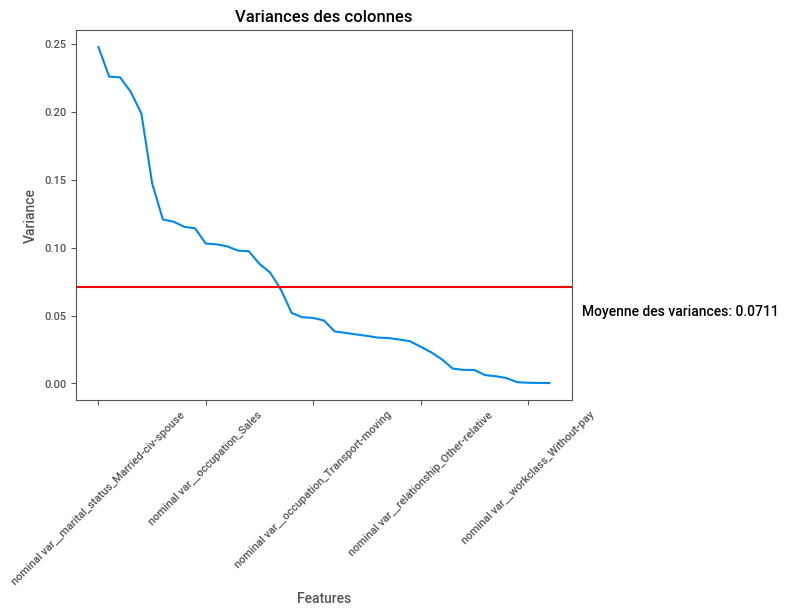

In [68]:
from matplotlib import pyplot as plt

var = X_transform.var(axis=0)
var = var.sort_values(ascending=False)
print('Moyenne des variances:', var.mean())

ax = var.plot()
ax.axhline(y= var.mean(), color='red')
ax.text(45, 0.05, f'Moyenne des variances: {round(var.mean(), 5)}')
plt.title('Variances des colonnes')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()

#### On détermine notre seuil de variance

count    43.000000
mean      0.071100
std       0.068759
min       0.000314
25%       0.020311
50%       0.046359
75%       0.102675
max       0.247534
dtype: float64


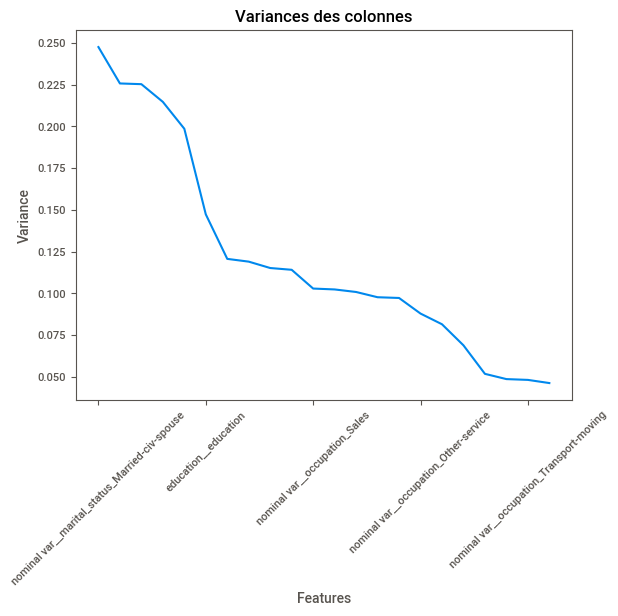

In [76]:
variance_treshold = 0.04

print(var.describe())

ax = var[var > variance_treshold].plot()
plt.title('Variances des colonnes')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.show()

In [77]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold= variance_treshold)
selector.fit_transform(X_transform)
X_cols_retained = np.array(np.asarray(list(X_transform)))[selector.get_support()]
print('Colonnes restantes: ', len(X_cols_retained))

Colonnes restantes:  22


### VarianceThreshold

In [109]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=Warning)

pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            GradientBoostingClassifier(max_depth=5, random_state=42))

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4195
           1       0.80      0.65      0.71      1429

    accuracy                           0.87      5624
   macro avg       0.84      0.80      0.81      5624
weighted avg       0.86      0.87      0.86      5624



In [112]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
variance_treshold = .0001
k = 25
kbest_test = chi2

pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            SelectKBest(kbest_test, k = k),
            VarianceThreshold(variance_treshold),
            ).fit_transform(X_train, y_train)
print(len(pipe.columns))

pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            SelectKBest(kbest_test, k = k),
            VarianceThreshold(variance_treshold),
            GradientBoostingClassifier(max_depth=5, random_state=42))

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

25
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4195
           1       0.80      0.63      0.71      1429

    accuracy                           0.87      5624
   macro avg       0.84      0.79      0.81      5624
weighted avg       0.86      0.87      0.86      5624



## chi2

### value
plus value est grand plus la variable à de l'importance

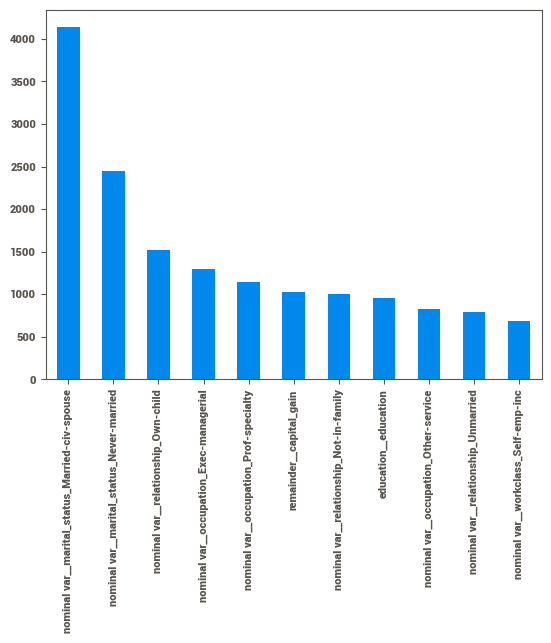

In [50]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler())
X_transform = pipe.fit_transform(X_train, y_train)

chi_scores = chi2(X_transform, y_train)

chi_values = pd.Series(chi_scores[0], index = X_transform.columns).sort_values(ascending=False)
chi_values.loc[lambda x: x > 600].plot.bar()
plt.show()

### p-value
Si p-value > 0.05 est grande, moins la variable a d'importance

<Axes: >

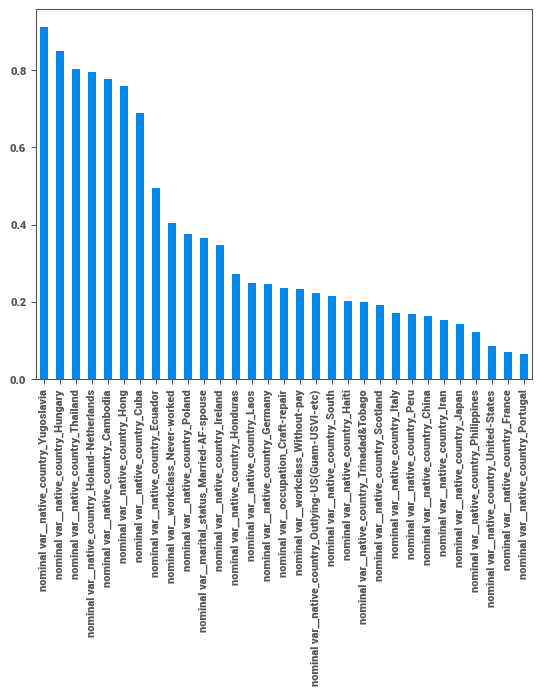

In [54]:
p_values = pd.Series(chi_scores[1], index = X_transform.columns).sort_values(ascending=False)
p_values.loc[lambda x: x > 0.05].plot.bar()

In [58]:
pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            SelectKBest(chi2, k = 30),
            VarianceThreshold(threshold= variance_treshold))

X_transform = pipe.fit_transform(X_train, y_train)
display(X_transform.head())
print(X_transform.shape)


education__education  binary var__sex_Male  \
30775              0.000000                   1.0   
3197               0.733333                   0.0   
21503              0.000000                   1.0   
15526              0.933333                   1.0   
3391               0.800000                   0.0   

       nominal var__workclass_Private  \
30775                             1.0   
3197                              0.0   
21503                             1.0   
15526                             0.0   
3391                              0.0   

       nominal var__marital_status_Married-civ-spouse  \
30775                                             1.0   
3197                                              0.0   
21503                                             1.0   
15526                                             1.0   
3391                                              0.0   

       nominal var__marital_status_Never-married  \
30775                                        0.0   
3197                                         1.0   
21503                                        0.0   
15526                                        0.0   
3391                                         0.0   

       nominal var__occupation_Adm-clerical  \
30775                                   0.0   
3197                                    0.0   
21503                                   0.0   
15526                                   0.0   
3391                                    0.0   

       nominal var__occupation_Exec-managerial  \
30775                                      0.0   
3197                                       0.0   
21503                                      0.0   
15526                                      0.0   
3391                                       0.0   

       nominal var__occupation_Machine-op-inspct  \
30775                                        0.0   
3197                                         0.0   
21503                                        0.0   
15526                                        0.0   
3391                                         0.0   

       nominal var__occupation_Other-service  \
30775                                    0.0   
3197                                     0.0   
21503                                    0.0   
15526                                    0.0   
3391                                     0.0   

       nominal var__occupation_Prof-specialty  \
30775                                     0.0   
3197                                      0.0   
21503                                     0.0   
15526                                     1.0   
3391                                      0.0   

       nominal var__relationship_Not-in-family  \
30775                                      0.0   
3197                                       0.0   
21503                                      0.0   
15526                                      0.0   
3391                                       1.0   

       nominal var__relationship_Own-child  \
30775                                  0.0   
3197                                   1.0   
21503                                  0.0   
15526                                  0.0   
3391                                   0.0   

       nominal var__relationship_Unmarried  nominal var__relationship_Wife  \
30775                                  0.0                             0.0   
3197                                   0.0                             0.0   
21503                                  0.0                             0.0   
15526                                  0.0                             0.0   
3391                                   0.0                             0.0   

       nominal var__race_Black  nominal var__race_White  
30775                      0.0                      1.0  
3197                       0.0                      0.0  
21503                      0.0                      1.0  
15526                    

(37701, 16)


In [80]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            SelectKBest(chi2, k = 20),
            RandomForestClassifier(max_features='sqrt', n_jobs=-1, max_depth=9))
# pipe.get_params()

parameters = {
    'selectkbest__k': np.linspace(20, 50, 5, dtype=int),
    'randomforestclassifier__max_samples': np.linspace(500, 1000, 5, dtype=int),
   # 'randomforestclassifier__max_depth': np.linspace(3, 15, 5, dtype=int)
}
grid = GridSearchCV(pipe, param_grid=parameters, cv=5).fit(X_train, y_train)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('education',
                                                                         OrdinalEncoder(categories=[['Preschool',
                                                                                                     '1st-4th '
                                                                                                     'grade',
                                                                                                     '5th-6th '
                                                                                                     'grade',
                                                                                                     '7th-8th '
                                                                                                     'grade',
                                                                                                     '9th '
                                                                                                     'grade',
                                                                                                     '10th '
                                                                                                     'grade',
                                                                                                     '11th '
                                                                                                     'grade',
                                                                                                     '12th '
                                                                                                     'grade',
                                                                                                     'Assoc-voc',
                                                                                                     'Assoc-acdm',
                                                                                                     'Some-college',
                                                                                                     'Bachelors',
                                                                                                     'Masters',
                                                                                                     'Doctora...
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'native_country'])])),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=20,
                                                    score_func=<function chi2 at 0x12dd6e5c0>)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=9,
                                                               n_jobs=-1))]),
             param_grid={'randomforestclassifier__max_samples': array([ 500,  625,  750,  875, 1000]),
                         'selectkbest__k': array([20, 27, 35, 42, 50])})

In [82]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print(grid.best_params_)

p = make_pipeline(
            create_transformers(),
            MinMaxScaler(),
            SelectKBest(chi2, k = 50))

X_transform = p.fit_transform(X_train, y_train)
feat = grid.best_estimator_['randomforestclassifier'].feature_importances_
f = pd.DataFrame({'features': np.array(list(X_transform)), 'score': feat})
f.sort_values(by=['score'], ascending=False, inplace=True)
f

              precision    recall  f1-score   support

           0       0.56      0.95      0.71      3283
           1       0.00      0.00      0.00      1741
           2       0.53      0.53      0.53      1082
           3       0.00      0.00      0.00       548

    accuracy                           0.56      6654
   macro avg       0.27      0.37      0.31      6654
weighted avg       0.36      0.56      0.44      6654

{'randomforestclassifier__max_samples': 1000, 'selectkbest__k': 50}


features     score
46                                     remainder__age  0.126225
0                                education__education  0.111992
47                            remainder__capital_gain  0.111005
49                          remainder__hours_per_week  0.104514
7      nominal var__marital_status_Married-civ-spouse  0.101454
9           nominal var__marital_status_Never-married  0.038120
48                            remainder__capital_loss  0.036318
1                                binary var__sex_Male  0.031706
20             nominal var__occupation_Prof-specialty  0.026066
14            nominal var__occupation_Exec-managerial  0.024991
25            nominal var__relationship_Not-in-family  0.019774
4                      nominal var__workclass_Private  0.017894
28                nominal var__relationship_Unmarried  0.016230
33                            nominal var__race_White  0.015389
27                nominal var__relationship_Own-child  0.015138
6             nominal var__workclass_Self-emp-not-inc  0.014038
29                     nominal var__relationship_Wife  0.013879
18              nominal var__occupation_Other-service  0.013104
31                            nominal var__race_Black  0.013079
22                      nominal var__occupation_Sales  0.011955
3                    nominal var__workclass_Local-gov  0.011730
5                 nominal var__workclass_Self-emp-inc  0.011263
2                  nominal var__workclass_Federal-gov  0.010915
12               nominal var__occupation_Adm-clerical  0.009336
23               nominal var__occupation_Tech-support  0.008465
30               nominal var__race_Asian-Pac-Islander  0.008363
17          nominal var__occupation_Machine-op-inspct  0.006956
16          nominal var__occupation_Handlers-cleaners  0.006929
24           nominal var__occupation_Transport-moving  0.006751
15            nominal var__occupation_Farming-fishing  0.006687
10              nominal var__marital_status_Separated  0.006282
21            nominal var__occupation_Protective-serv  0.006090
11                nominal var__marital_status_Widowed  0.005540
26           nominal var__relationship_Other-relative  0.005398
41                 nominal var__native_country_Mexico  0.005349
8   nominal var__marital_status_Married-spouse-absent  0.004407
32                            nominal var__race_Other  0.003364
43            nominal var__native_country_Puerto-Rico  0.002006
37                nominal var__native_country_England  0.001783
39                  nominal var__native_country_India  0.001562
19            nominal var__occupation_Priv-house-serv  0.001547
36            nominal var__native_country_El-Salvador  0.001428
44                 nominal var__native_country_Taiwan  0.000902
40                nominal var__native_country_Jamaica  0.000890
35     nominal var__native_country_Dominican-Republic  0.000810
34               nominal var__native_country_Columbia  0.000724
45                nominal var__native_country_Vietnam  0.000543
38              nominal var__native_country_Guatemala  0.000510
42              nominal var__native_country_Nicaragua  0.000355
13               nominal var__occupation_Armed-Forces  0.000245

              precision    recall  f1-score   support

           0       0.55      0.68      0.61      3250
           1       0.25      0.17      0.20      1753
           2       0.45      0.47      0.46      1115
           3       0.15      0.10      0.12       536

    accuracy                           0.46      6654
   macro avg       0.35      0.35      0.35      6654
weighted avg       0.42      0.46      0.44      6654



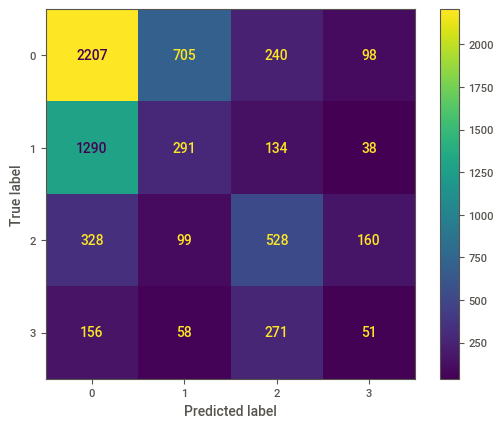

In [15]:
parameters = {
    'variancethreshold__threshold': np.linspace(0, 0.045, 20),
    #'standardscaler': [StandardScaler(), MinMaxScaler(), Normalizer()]
}

grid = GridSearchCV(pipe, param_grid=parameters, cv=5).fit(X_train, y_train)

pipe.fit(X_train, y_train)

# Access the best set of parameters
best_params = grid.best_params_
print('BEST PARAMS ::', best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
#print('BEST PIPE ::', best_pipe)

y_pred = best_pipe.predict(X_test)

print(classification_report(y_test, y_pred))

# result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()

In [148]:
pipe = make_pipeline(
            create_transformers(),
            VarianceThreshold(threshold= best_params['variancethreshold__threshold']),
            StandardScaler())
X_transform = pipe.fit_transform(X_train, y_train)

feat = best_pipe['randomforestclassifier'].feature_importances_

f = pd.DataFrame({'features': np.array(list(X_transform)), 'score': feat})
f.sort_values(by=['score'], ascending=False, inplace=True)
f

features     score
35                                     remainder__age  0.327331
38                          remainder__hours_per_week  0.170544
0                                education__education  0.086147
36                            remainder__capital_gain  0.062205
8      nominal var__marital_status_Married-civ-spouse  0.031367
37                            remainder__capital_loss  0.028594
1                                binary var__sex_Male  0.019146
4                      nominal var__workclass_Private  0.018253
10          nominal var__marital_status_Never-married  0.017589
34          nominal var__native_country_United-States  0.017464
32                            nominal var__race_White  0.013752
15            nominal var__occupation_Exec-managerial  0.011301
20             nominal var__occupation_Prof-specialty  0.010804
22                      nominal var__occupation_Sales  0.010703
6             nominal var__workclass_Self-emp-not-inc  0.010429
13               nominal var__occupation_Adm-clerical  0.010215
14               nominal var__occupation_Craft-repair  0.010153
25            nominal var__relationship_Not-in-family  0.010010
31                            nominal var__race_Black  0.009811
3                    nominal var__workclass_Local-gov  0.009342
19              nominal var__occupation_Other-service  0.008944
7                    nominal var__workclass_State-gov  0.007985
27                nominal var__relationship_Own-child  0.007953
18          nominal var__occupation_Machine-op-inspct  0.007465
24           nominal var__occupation_Transport-moving  0.006785
28                nominal var__relationship_Unmarried  0.006768
23               nominal var__occupation_Tech-support  0.006392
5                 nominal var__workclass_Self-emp-inc  0.006360
2                  nominal var__workclass_Federal-gov  0.006337
17          nominal var__occupation_Handlers-cleaners  0.005889
30               nominal var__race_Asian-Pac-Islander  0.005814
11              nominal var__marital_status_Separated  0.005694
29                     nominal var__relationship_Wife  0.005452
16            nominal var__occupation_Farming-fishing  0.005421
26           nominal var__relationship_Other-relative  0.005088
12                nominal var__marital_status_Widowed  0.004582
21            nominal var__occupation_Protective-serv  0.004581
33                 nominal var__native_country_Mexico  0.003877
9   nominal var__marital_status_Married-spouse-absent  0.003455